You will need the find TOA, calculating deficits, and calculating gradients parts of this script. Below that are a bunch of plotting things that you may find useful, including a plot or two that was in the paper.

This script has been optimized for MY data and will require changes (i.e., the "drop_bad_rh" function for a specific sticknet that is called in the deficit function)

In [1]:
import pandas as pd
import datetime as dt
from functions import calc_dewpoint, calc_thetae, calc_thetav
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as md

%pylab inline
#sns = pd.read_csv('VSE_Data_1Hz.csv')
SNSfile = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/ALL_EVENTS_full_thermo_R20km.csv'
sns = pd.read_csv(SNSfile)


def get_1hz(date, probe, starttime, duration, seconds=False):
    directory= '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/data_1s/'
    datafile = "{}{}_{}.csv".format(directory, probe, date)
    data = pd.read_csv(datafile, header=0, index_col = 'time', parse_dates=['time'], date_parser=pd.to_datetime)
    
    if seconds == False:
        # handle when data from two days is needed
        s = (starttime-dt.timedelta(minutes=1))
        e = (starttime+dt.timedelta(minutes=duration))
        if s.strftime('%d')!= e.strftime('%d'):
            datafile = "{}{}_{}.csv".format(directory, probe, e.strftime('%Y%m%d'))
            data2 = pd.read_csv(datafile, header=0, index_col = 'time', parse_dates=['time'], date_parser=pd.to_datetime)
            data = pd.concat([data.iloc[0:-1],data2])

        return data[starttime:starttime+dt.timedelta(minutes=duration)]
    if seconds == True:
        # handle when data from two days is needed
        s = (starttime-dt.timedelta(minutes=1))
        e = (starttime+dt.timedelta(seconds=duration))
        if s.strftime('%d')!= e.strftime('%d'):
            datafile = "{}{}_{}.csv".format(directory, probe, e.strftime('%Y%m%d'))
            data2 = pd.read_csv(datafile, header=0, index_col = 'time', parse_dates=['time'], date_parser=pd.to_datetime)
            data = pd.concat([data.iloc[0:-1],data2])

        return data[starttime:starttime+dt.timedelta(seconds=duration)]

Populating the interactive namespace from numpy and matplotlib


# find TOA

Manually set delta_k for each event/whole project. This value is arbitrary. It is the change in temp that is used to determine the cold pool edge location. You can tweak this script to save the TOA times back into the CSV. Note: some of them will likely require manual fixes, and I'd advise that you create a column in the CSV to track any modifications

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


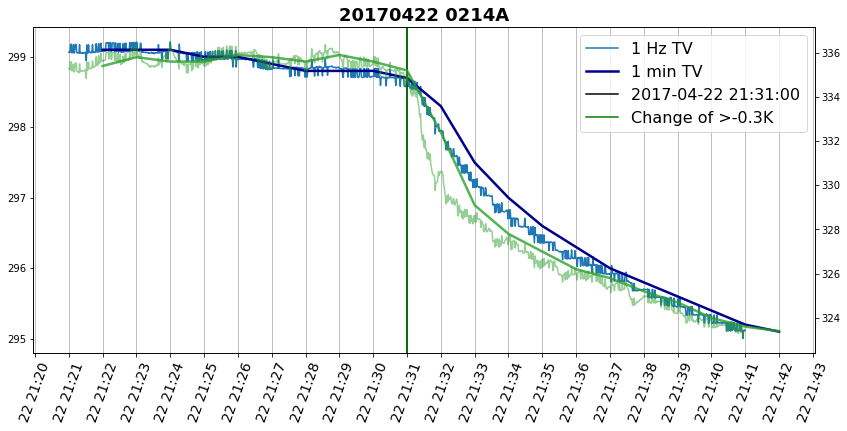

In [2]:


delta_k = {'20160331':0.15,
           '20160430':0.30,
           '20170301':0.30,
           '20170310':0.27,
           '20170321':0.40,
           '20170325':0.30,
           '20170327':0.30,
           '20170422':0.30,
           '20170430':0.30}

savedir= '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/toa_test/'

for i in [sns.index[73]]:
    # unpack data
    snid = sns.loc[i]['ID']
    toa = pd.to_datetime(sns.loc[i]['TOA'])
    date = sns.loc[i]['date']
    
    # get data around TOA -> 10 min on each side
    start = toa-dt.timedelta(minutes=10)
    duration=20
    met = get_1hz(date, snid[0:5], start, duration)
    dewp = calc_dewpoint(met['T'],met['RH'])
    thetav = calc_thetav(met['T'], dewp, met['P'])
    thetae = calc_thetae(met['T'], dewp, met['P'])
    
    fig = figure(figsize=(14,6))
    plt.xticks(rotation=70, fontsize=14)
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(pd.to_datetime(met.index), thetae, label='1 Hz TE', color='C2', alpha=0.5)
    te_1min = np.round(thetae.resample('1Min', label='right').mean(),1)
    ax2.plot(te_1min.index, te_1min, color='C2', linewidth=2.5, alpha=0.8)
    
    ax.plot(pd.to_datetime(met.index), thetav, label='1 Hz TV')
    
    tv_1min = np.round(thetav.resample('1Min', label='right').mean(),1)
    ax.plot(tv_1min.index, tv_1min, color='darkblue', linewidth=2.5, label="1 min TV")

    xlocator = md.MinuteLocator(interval = 1)
    ax.xaxis.set_major_locator(xlocator)
    ax.grid(axis='x')
        
    # plot current toa
    ax.axvline(toa, color='k', label='{}'.format(toa))
    
    # plot methods toa (note, some will be off. check with methods table in manuscript)
    change=[]
    dk = -1*delta_k[str(date)]
    for i,val in enumerate(tv_1min):
        if i < (len(tv_1min) - 1):
            diff = tv_1min[i+1] - tv_1min[i]
            change.append(diff)
    idx = np.where(np.asarray(change) < dk)
    ax.axvline(tv_1min.index[idx[0][0]], color='g',label='Change of >{}K'.format(dk))

    plt.title('{} {}'.format(date, snid), fontsize=18, weight='bold')
    ax.legend(fontsize=16)
    
    plt.show()
    #plt.savefig('{}{}_{}.png'.format(savedir, date, snid), bbox_inches='tight')
    #plt.close()


In [ ]:
for i in sns.index[45:46]:
    # unpack data
    snid = sns.loc[i]['ID']
    toa = pd.to_datetime(sns.loc[i]['TOA'])
    date = sns.loc[i]['date']
    
    # get data around TOA -> 10 min on each side
    start = toa-dt.timedelta(minutes=10)
    duration=20
    met = get_1hz(date, snid[0:5], start, duration)
    dewp = calc_dewpoint(met['T'],met['RH'])
    thetav = calc_thetav(met['T'], dewp, met['P'])
    thetae = calc_thetae(met['T'], dewp, met['P'])
    
    fig = figure(figsize=(14,6))
    plt.xticks(rotation=70, fontsize=14)
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(pd.to_datetime(met.index), thetae, label='1 Hz TE', color='C2', alpha=0.5)
    te_1min = np.round(thetae.resample('1Min', label='right').mean(),1)
    ax2.plot(te_1min.index, te_1min, color='C2', linewidth=2.5, alpha=0.8)
    
    ax.plot(pd.to_datetime(met.index), thetav, label='1 Hz TV')
    
    tv_1min = np.round(thetav.resample('1Min', label='right').mean(),1)
    ax.plot(tv_1min.index, tv_1min, color='darkblue', linewidth=2.5, label="1 min TV")

    xlocator = md.MinuteLocator(interval = 1)
    ax.xaxis.set_major_locator(xlocator)
    ax.grid(axis='x')
        
    ax.axvline(toa, color='k', label='{}'.format(toa))
    plt.title('{} {}'.format(date, snid), fontsize=18, weight='bold')
    ax.legend(fontsize=16)

### TOA time check

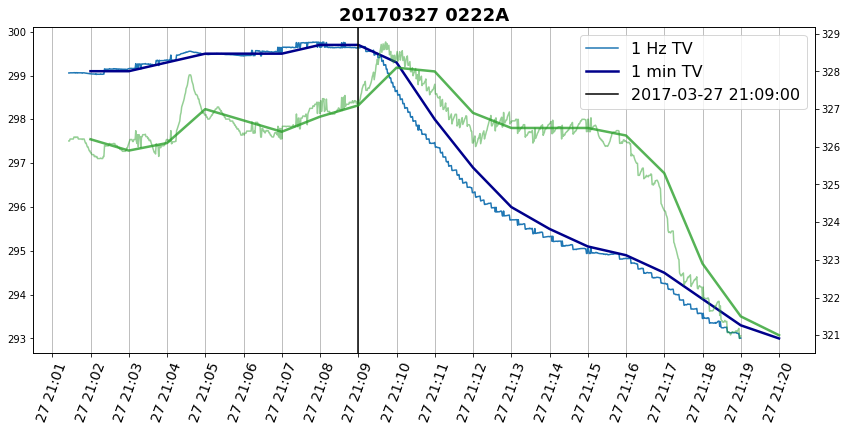

In [757]:
savedir= '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/toa_test/'

for i in sns.index[45:46]:
    # unpack data
    snid = sns.loc[i]['ID']
    toa = pd.to_datetime(sns.loc[i]['TOA'])
    date = sns.loc[i]['date']
    
    # get data around TOA -> 10 min on each side
    start = toa-dt.timedelta(minutes=10)
    duration=20
    met = get_1hz(date, snid[0:5], start, duration)
    dewp = calc_dewpoint(met['T'],met['RH'])
    thetav = calc_thetav(met['T'], dewp, met['P'])
    thetae = calc_thetae(met['T'], dewp, met['P'])
    
    fig = figure(figsize=(14,6))
    plt.xticks(rotation=70, fontsize=14)
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(pd.to_datetime(met.index), thetae, label='1 Hz TE', color='C2', alpha=0.5)
    te_1min = np.round(thetae.resample('1Min', label='right').mean(),1)
    ax2.plot(te_1min.index, te_1min, color='C2', linewidth=2.5, alpha=0.8)
    
    ax.plot(pd.to_datetime(met.index), thetav, label='1 Hz TV')
    
    tv_1min = np.round(thetav.resample('1Min', label='right').mean(),1)
    ax.plot(tv_1min.index, tv_1min, color='darkblue', linewidth=2.5, label="1 min TV")

    xlocator = md.MinuteLocator(interval = 1)
    ax.xaxis.set_major_locator(xlocator)
    ax.grid(axis='x')
        
    ax.axvline(toa, color='k', label='{}'.format(toa))
    plt.title('{} {}'.format(date, snid), fontsize=18, weight='bold')
    ax.legend(fontsize=16)
    
#     plt.savefig('{}{}_{}.png'.format(savedir, date, snid), bbox_inches='tight')
#     plt.close()

# calculating deficits 

In [3]:


def get_BSdist(SN, myvar):
    ''' finds the base state using a start (def_dist) and end (def_dist2) distance in km 
    (distance from TOA, which is placed at 0 m).
    
    myvar is either str TE or TV. '''
    def_dist = 15*1000 # 10 km, 10,000 m
    def_dist2 = 10*1000 # 8 km 

    starttime = pd.to_datetime(SN['TOA']) - dt.timedelta(minutes=30)
    met = get_1hz(SN['date'], SN['ID'][0:5], starttime, 30) # pull 30 mins, should be more than enough 

    u = SN['Ua']
    v = SN['Va']
    storm_speed = np.sqrt(u**2 + v**2)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled
    dist = abs(dist-dist[-1]) # distance going back in time starting at toa

    start = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0] # find where dist closest to 15
    end = np.where(abs(dist-def_dist2) == abs(dist-def_dist2).min())[0][0] # find where dist closest to 10
    change = np.nan
    
    #correction for short starts
    deldist = (def_dist-def_dist2) # delta distance from specified start and end distances
    if (end - start) < (deldist/storm_speed - 10) : # see if you have correct number of points
        start = 0
        ndist = storm_speed * delta_time
        end = np.where(abs(ndist-deldist) == abs(ndist-deldist).min())[0][0] # find 5 km from where data starts
        change = (ndist-ndist[-1])[0]
    

    dewp = calc_dewpoint(met['T'],met['RH'])
    if myvar == 'TV':
        var = calc_thetav(met['T'], dewp, met['P'])
    if myvar == 'TE':
        var = calc_thetae(met['T'], dewp, met['P'])

    bs = np.mean(var[start:end])
    return bs #met.index[start], met.index[end], change #<- use these when making methods plots

def drop_badRH(RH):
    drh = 30
    bad_locs=[]
    for i, val in enumerate(RH[0:-drh]):
        std=np.std(RH[i:i+drh-1])
        mean = np.average(RH[i:i+drh-1])
        if (RH[i+drh] > mean+8 )| (RH[i+drh] < mean-8):
            bad_locs.append(i+drh)
    RH[bad_locs]=np.nan   
    return RH

def get_distdef(SN, myvar, def_dist=15*1000):
    ''' def_dist is the distance in km that the deficit is considered.
    default is 10km'''

    starttime = pd.to_datetime(SN['TOA'])
    met = get_1hz(SN['date'], SN['ID'][0:5], starttime, 30) # pull 30 mins, should be more than enough 

    u = SN['Ua']
    v = SN['Va']
    storm_speed = np.sqrt(u**2 + v**2)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled

    endtime = starttime + dt.timedelta(seconds=599) 

    # find where distance array is closest to 10km
    end = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0]

    dewp = calc_dewpoint(met['T'],met['RH'])
    if myvar == 'TV':
        var = calc_thetav(met['T'], dewp, met['P'])
    if myvar == 'TE':
        var = calc_thetae(met['T'], dewp, met['P'])

    bs = get_BSdist(SN, myvar)
    

    if SN['ID'] == '0215A2': # using 10-15 km basestate, with corrected TOAs
        fix_0215A2 = {'TE':331.6284883813534, 
                      'TV':297.9980389891804}
        bs = fix_0215A2[myvar]
        
    if SN['ID'] == '0222A': # fix for weird RH spikes
        if myvar == 'TE':
            RH = drop_badRH(met['RH'].copy())
            dewp = calc_dewpoint(met['T'],RH)
            var = calc_thetae(met['T'], dewp, met['P'])
            
    minval = np.min(var.iloc[0:end+1])
    return  minval - bs#met.index[0], met.index[end]# <- use these when making methods plots#minval - bs#

In [35]:
#sns = pd.read_csv('VSE_Data_1Hz_gradtv.csv')
sns['TE_dist'] = np.nan
sns['TV_dist'] = np.nan

for SN in sns.index:
    if np.isnan(sns.loc[SN]['Ua']) == False:
        sns.loc[SN,'TE_dist'] = np.round(get_distdef(sns.loc[SN], 'TE'),2)
        sns.loc[SN,'TV_dist'] = np.round(get_distdef(sns.loc[SN], 'TV'),2)

# calculating gradients

In [3]:
def get_correction_angle(u, v, ref):
    ''' ref is the storm reflectivity angle'''
    theta_motion = np.rad2deg(np.arctan(v/u))
    if (theta_motion < 0) & (ref < 0):
        theta_correction = np.deg2rad(abs(ref) - abs(theta_motion)) 
    else:
        theta_correction = np.deg2rad(abs(ref - theta_motion))
  
    return theta_correction

def findnearest(array, value):
    array = np.asarray(array)
    return (np.abs(array-value)).argmin()

def get_tvgrad(SN, distance, pretoa=2*1000, posttoa=10*1000):
    ''' SN is the sticknet data
    pretoa is meters before toa to start using data
    posttoa is meters after toa to stop using data
    distance is distance in meters to calculate the max thetav change. This should equal 1000 if you 
    want to be consistent with McDonald and Weiss 2021'''
    
    # check for empty files
    ref = SN['storm_ref_angle']
    if np.isnan(ref)!= True:
    
        snid = SN['ID']
        u = SN['Ua']
        v = SN['Va']
        storm_speed = np.sqrt(u**2 + v**2)
        date = SN['date']
        toa = pd.to_datetime(SN['TOA'])

        # grab time 15 minutes before toa and 30 minutes after, should be big enough buffer
        duration = 45 # note: found bug on 3/25/2020... duration was not set and was still 20(?). However,
                      # this does not change any of the values so we good
        met = get_1hz(date,snid[0:5], toa - dt.timedelta(minutes=15), 45)
        dewp = calc_dewpoint(met['T'], met['RH'])
        tv = calc_thetav(met['T'], dewp, met['P'])

        # create distance array based on correction angle
        delta_time = (met.index[:]-met.index[0]).seconds
        dist = storm_speed * delta_time
        theta_c = get_correction_angle(u,v,ref)
        new_dist = dist * np.cos(theta_c)

        # center new_dist on TOA, negative values are before TOA, postive are after
        toa_idx = np.where(met.index==toa)[0][0]
        new_dist = new_dist - new_dist[toa_idx]

        # find start and end for data based on distance before and after toa
        if (date == 20160331 ) & (snid == '0215A1'): # correction for next storm coming up
            posttoa = 5*1000
        start_idx = findnearest(new_dist, -1*pretoa)
        end_idx = findnearest(new_dist, posttoa)
        new_dist = new_dist[start_idx: end_idx]
        tv = tv[start_idx:end_idx]

        # create array to hold start and end indices equal to 1 km distance
        idx = []
        counter = 0
        for i, val in enumerate(new_dist[:]):
            i2 = findnearest(new_dist, val+distance)
            if i2 == duration*60: 
                counter+=1
            if counter > 1: # if max index is used more than once, then skip everything else
                idx.append([np.nan, np.nan])
            if counter <=1:
                idx.append([i,i2])
                
        dTV_dn = [(tv[i[1]] - tv[i[0]])/(distance/1000) for i in idx if np.isnan(i[0])== False]
        # EDIT 8 Sept 2020... I realized this wasnt divided by distance. It doesn't matter because
        # I had (THANK GOODNESS) been using 1 km distance, but I needed the edit now that I'm varying
        # the distance
        
        grad = np.amin(dTV_dn)
    else:
        snid = SN['ID']
        grad = np.nan
    return snid, grad#met.index[start_idx], met.index[end_idx]#s

In [37]:
#sns = pd.read_csv('VSE_Data_1Hz_thermo_distance.csv', na_values=-999)

# sns['dTVdn'] = np.nan
for SN in sns.index:
    sticknet, grad = get_tvgrad(sns.loc[SN], 1000) # 1 km spacing
    sns.loc[SN,'dTVdn'] = np.round(grad,2)

In [35]:
#sns.to_csv('VSE_Data_1Hz_thermo_distance.csv',index = False )
sns.to_csv(SNSfile, index=False)

### plots to check methods work

make sure the deficit, base state, or grad tv functions are returning times and not values

In [15]:
# deficits


savedir= '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/methods_test/'

#sns = pd.read_csv('VSE_Data_1Hz.csv', na_values='-999' )
sns = pd.read_csv(SNSfile, na_values='-999' )

for i in sns.index[0:1]:
    if np.isnan(sns.loc[i]['Ua']) == False:
        # unpack data
        snid = sns.loc[i]['ID']
        toa = pd.to_datetime(sns.loc[i]['TOA'])
        date = sns.loc[i]['date']

        # get data around TOA -> 10 min on each side
        start = toa-dt.timedelta(minutes=20)
        duration=40
        met = get_1hz(date, snid[0:5], start, duration)
        dewp = calc_dewpoint(met['T'],met['RH'])
       
        if snid == '0222A': # fix for weird RH spikes
            RH = drop_badRH(met['RH'].copy())
            dewp = calc_dewpoint(met['T'],RH)
            
        thetav = calc_thetav(met['T'], dewp, met['P'])
        thetae = calc_thetae(met['T'], dewp, met['P'])

        fig = figure(figsize=(14,6))
        plt.xticks(rotation=90, fontsize=12)
        ax = plt.gca()

        ax2 = ax.twinx()
        ax2.plot(pd.to_datetime(met.index), thetae, label='1 Hz TE', color='C2', alpha=0.5)
        te_1min = np.round(thetae.resample('1Min', label='right').mean(),1)
        ax2.plot(te_1min.index, te_1min, color='C2', linewidth=2.5, alpha=0.8)

        ax.plot(pd.to_datetime(met.index), thetav, label='1 Hz TV')

        tv_1min = np.round(thetav.resample('1Min', label='right').mean(),1)
        ax.plot(tv_1min.index, tv_1min, color='darkblue', linewidth=2.5, label="1 min TV")

        xlocator = md.MinuteLocator(interval = 1)
        ax.xaxis.set_major_locator(xlocator)
        ax.grid(axis='x')

        ax.axvline(toa, color='k', label='{}'.format(toa.strftime('%H%M UTC')))
        plt.title('{} {}'.format(date, snid), fontsize=18, weight='bold')
        ax.legend(fontsize=16)

        # old methods
#         axvspan(toa-dt.timedelta(minutes=20),toa-dt.timedelta(minutes=15), color='k', alpha=0.1)
#         axvspan(toa,toa+dt.timedelta(minutes=10), color='k', alpha=0.1)

        # new methods
        bsstart, bsend, change= get_BSdist(sns.loc[i], 'TV')
        defstart, defend = get_distdef(sns.loc[i], 'TV')

        axvspan(bsstart, bsend, color='C0', alpha=0.25 )
        axvspan(defstart, defend, color='C0', alpha=0.2 )
        
        
        # check for change in base state method
        if bsstart == met.index[0]:
            ax.text(toa-dt.timedelta(minutes=20), np.min(thetav)+.2,
                    'BS start: {} m'.format(-1*np.round(change,0)), fontsize=18)
        plt.savefig('{}{}_{}.png'.format(savedir, date, snid), bbox_inches='tight')
        plt.close()

In [19]:
dt.datetime(2016,3,31,23,7) - bsstart 

Timedelta('0 days 00:31:46')

In [25]:
# theta v gradients

savedir= '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/methods_test/'

#sns = pd.read_csv('VSE_Data_1Hz.csv', na_values='-999' )
sns = pd.read_csv(SNSfile, na_values='-999' )

for i in sns.index[0:1]:
    if np.isnan(sns.loc[i]['Ua']) == False:
        # unpack data
        snid = sns.loc[i]['ID']
        toa = pd.to_datetime(sns.loc[i]['TOA'])
        date = sns.loc[i]['date']

        # get data around TOA -> 10 min on each side
        start = toa-dt.timedelta(minutes=20)
        duration=40
        met = get_1hz(date, snid[0:5], start, duration)
        dewp = calc_dewpoint(met['T'],met['RH'])
       
        if snid == '0222A': # fix for weird RH spikes
            RH = drop_badRH(met['RH'].copy())
            dewp = calc_dewpoint(met['T'],RH)
            
        thetav = calc_thetav(met['T'], dewp, met['P'])
        thetae = calc_thetae(met['T'], dewp, met['P'])

        fig = figure(figsize=(14,6))
        plt.xticks(rotation=90, fontsize=12)
        ax = plt.gca()

        ax2 = ax.twinx()
        ax2.plot(pd.to_datetime(met.index), thetae, label='1 Hz TE', color='C2', alpha=0.5)
        te_1min = np.round(thetae.resample('1Min', label='right').mean(),1)
        ax2.plot(te_1min.index, te_1min, color='C2', linewidth=2.5, alpha=0.8)

        ax.plot(pd.to_datetime(met.index), thetav, label='1 Hz TV')

        tv_1min = np.round(thetav.resample('1Min', label='right').mean(),1)
        ax.plot(tv_1min.index, tv_1min, color='darkblue', linewidth=2.5, label="1 min TV")

        xlocator = md.MinuteLocator(interval = 1)
        ax.xaxis.set_major_locator(xlocator)
        ax.grid(axis='x')

        ax.axvline(toa, color='k', label='{}'.format(toa.strftime('%H%M UTC')))
        plt.title('{} {}'.format(date, snid), fontsize=18, weight='bold')
        ax.legend(fontsize=16)

    
        # new methods
        gradstart, gradend = get_tvgrad(sns.loc[i], 1000, posttoa=10*1000) 

        axvspan(gradstart, gradend, color='C0', alpha=0.25 )
        
        plt.savefig('{}GRAD_{}_{}.png'.format(savedir, date, snid), bbox_inches='tight')
        plt.close()

# Things needed for the paper based on these methods

### Methods Table

In [11]:
import pandas as pd
import datetime as dt
import numpy as np

In [17]:
# create text that can be copy pasted into a latex script to quickly fill in a table

SNSfile = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/ALL_EVENTS_full_thermo_R20km.csv'
sns = pd.read_csv(SNSfile)

table =sns[(sns['type']=='R') | (sns['type']=='T') | (sns['date']==20170430) | (sns['date']==20170310)].copy()
TOA = pd.to_datetime(table['TOA'])
table.loc[:,'TOA'] = TOA

table.sort_values('TOA', inplace=True)

for i in table.index:

    date = dt.datetime.strptime(str(table.loc[i]['date']),'%Y%m%d').strftime("%d %b %Y")
    nameID = table.loc[i]['N_ID']
    try:
        if np.isnan(nameID) == True:
            nameID = table.loc[i]['ID']
    except TypeError:
        pass
    
    if table.loc[i]['type']=='NR':
        nameID = nameID+'*'
        
    TOA = pd.to_datetime(table.loc[i]['TOA']).strftime('%d/%H%M')
    stormu = table.loc[i]['Ua']
    stormv = table.loc[i]['Va']
    sangle = table.loc[i]['storm_ref_angle']
    
    if (date == '25 Mar 2017') & (nameID == 'SPBG'):
        sangle = str(sangle)+'$^{\dag}$'
    if (date == '27 Mar 2017') & (nameID == 'SHLG'):
        sangle = str(sangle)+'$^{\dag}$'
    if (date == '27 Mar 2017') & (nameID == 'SEMT'):
        sangle = str(sangle)+'$^{\dag}$'
        
    
    mods = ''
    TOAmods = table.loc[i]['TOA_mods']
    BSdistmods = table.loc[i]['Bsdist_mods']

    if np.isnan(TOAmods) != True:
        mods = f'TOA: {TOAmods}'
    if np.isnan(BSdistmods) != True:
        mods = f'BS: {BSdistmods}'
    
    print(date,'&', nameID, '&', TOA, '&', f'{stormu}, {stormv}', '&', sangle, '&', mods, '\\\\')

31 Mar 2016 & 0220A & 31/2216 & 15.4, 3.9 & -6.0 &  \\
31 Mar 2016 & 0222A & 31/2216 & 15.4, 3.9 & -30.0 & BS: 10.5 \\
31 Mar 2016 & 0221A & 31/2228 & 19.2, 7.7 & -19.0 &  \\
31 Mar 2016 & 0217A & 31/2232 & 15.0, 3.8 & -40.0 & BS: 10.6 \\
31 Mar 2016 & SSJH & 31/2249 & 17.8, 3.6 & -60.0 &  \\
31 Mar 2016 & 0218A & 31/2249 & 17.8, 3.6 & -22.0 &  \\
31 Mar 2016 & SSJH & 31/2307 & 16.6, 3.3 & -30.0 & BS: 32.2 \\
30 Apr 2016 & SDTR & 30/2142 & 9.6, 16.0 & 32.0 & TOA: -1.0 \\
01 Mar 2017 & SDTR & 01/1903 & 29.2, 7.3 & -55.0 &  \\
01 Mar 2017 & 0103A & 01/1945 & 26.5, 7.6 & -11.0 &  \\
01 Mar 2017 & 0109A & 01/1950 & 25.6, 7.3 & 15.0 &  \\
10 Mar 2017 & SLBG* & 10/0507 & 24.1, -8.0 & -68.0 &  \\
10 Mar 2017 & SLYN & 10/0525 & 23.6, -7.9 & -51.0 &  \\
10 Mar 2017 & SSJH* & 10/0535 & 20.8, -5.2 & -61.0 & TOA: -1.0 \\
10 Mar 2017 & SPBG & 10/0541 & 21.3, -10.7 & -60.0 &  \\
10 Mar 2017 & SEMT* & 10/0559 & 21.4, -8.0 & -60.0 &  \\
10 Mar 2017 & STLM & 10/0609 & 24.0, -5.3 & -56.0 &  \\
10 Mar 20

## cold pool edge relative deficit paths

In [5]:
import cmocean.cm as cmo

def get_circle(angles, radius):
    ''' angles must be in radians'''
    return radius*np.cos(angles), radius*np.sin(angles)

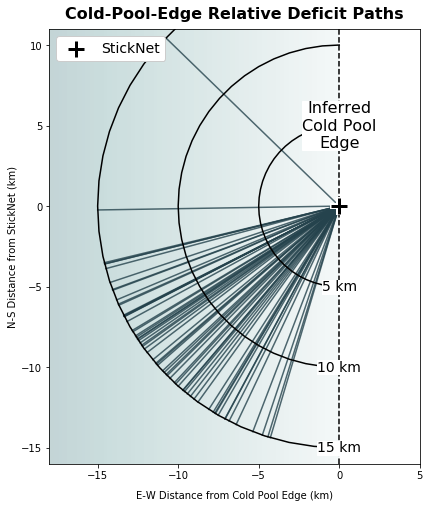

In [5]:

sns = pd.read_csv(SNSfile)

fig = plt.figure(figsize(8,8))
ax = fig.add_subplot(111, aspect='equal')

def plot_cprel(ax):
    ax.set_title('Cold-Pool-Edge Relative Deficit Paths', fontsize=16, y = 1.01, weight='bold')
    ax.scatter(0,0, marker = '+', s=(18**2), linewidth=6, color='w', zorder=30)
    ax.scatter(0,0, marker = '+', s=(16**2), linewidth=3, color='k', zorder=30, label='StickNet')


    for ID in sns.index:
        SN = sns.loc[ID]

        a = np.deg2rad(SN['storm_ref_angle'])
        ua = np.deg2rad(SN['Ua'])
        va = np.deg2rad(SN['Va'])
        new_angle = np.arctan(va/ua) - a

        ax.plot([0, -15*np.cos(new_angle)], [0,-15*(np.sin(new_angle))], color='#25434d', 
                linewidth=1.5, alpha=0.8)

    # Location of Cold Pool
    ax.axvline(0, color='k', linestyle='--')
    ax.text(0,5, 'Inferred\nCold Pool\nEdge', fontsize=16, horizontalalignment='center',verticalalignment='center',
             bbox=dict(facecolor='w', edgecolor='w', pad=0))

    # Range Rings
    x,y = get_circle(np.arange(np.pi/2,2*np.pi + np.pi/30 -np.pi/2, np.pi/30), 5)
    ax.plot(x,y, color='k')

    x,y = get_circle(np.arange(np.pi/2,2*np.pi + np.pi/30 -np.pi/2, np.pi/30), 10)
    ax.plot(x,y, color='k')

    x,y = get_circle(np.arange(np.pi/2,2*np.pi + np.pi/30 -np.pi/2, np.pi/30), 15)
    ax.plot(x,y, color='k')


    ax.text(0,-15, '15 km',  horizontalalignment='center',verticalalignment='center', fontsize=14, \
             bbox=dict(facecolor='w', edgecolor='w', pad=0))
    ax.text(0, -10, '10 km',  horizontalalignment='center',verticalalignment='center', fontsize=14, \
             bbox=dict(facecolor='w', edgecolor='w', pad=0))
    ax.text(0, -5,  '5 km',  horizontalalignment='center',verticalalignment='center', fontsize=14, \
             bbox=dict(facecolor='w', edgecolor='w', pad=0))


    ax.set_xlim(-18,5)
    ax.set_ylim(-16,11)
    # ax.set_xticks(fontsize=14)
    # ax.set_yticks(fontsize=14)
    ax.set_xlabel('E-W Distance from Cold Pool Edge (km)', labelpad=10)
    ax.set_ylabel('N-S Distance from StickNet (km)')

    # add cold pool 
    xs = np.arange(-18,.1,.1)
    ys =  np.arange(-16,15.1,.100)
    zs = [[x for x in xs] for y in ys]
    ax.contourf(xs, ys, zs,levels=xs, colors=cm.bone(np.linspace(.7,.95, len(xs))),alpha=0.6 );
    
    
    ax.legend(loc=2, fontsize=14, framealpha=1);
    
    
plot_cprel(ax)




## Code to plot deficits relative to distance

In [10]:




def var_dist_rel(SN, myvar):
    ''' def_dist is the distance in km that the deficit is considered.
    default is 10km'''

    toa = pd.to_datetime(SN['TOA'])
    starttime =  toa - dt.timedelta(minutes=20)
    met = get_1hz(SN['date'], SN['ID'][0:5], starttime, 50) # pull 30 mins, should be more than enough 

    u = SN['Ua']
    v = SN['Va']
    storm_speed = np.sqrt(u**2 + v**2)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled
    
    # center new_dist on TOA, negative values are before TOA, postive are after
    toa_idx = np.where(met.index==toa)[0][0]
    dist = dist - dist[toa_idx]
    
    # find where distance array is closest to 
    start_dist = -5*1000
    start = np.where(abs(dist-start_dist) == abs(dist-start_dist).min())[0][0]
    def_dist = 20*1000
    end = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0]

    dewp = calc_dewpoint(met['T'],met['RH'])
    if myvar == 'TV':
        var = calc_thetav(met['T'], dewp, met['P'])
    if myvar == 'TE':
        var = calc_thetae(met['T'], dewp, met['P'])
        
    if SN['ID'] == '0222A': # fix for weird RH spikes
        if myvar == 'TE':
            RH = drop_badRH(met['RH'].copy())
            dewp = calc_dewpoint(met['T'],RH)
            var = calc_thetae(met['T'], dewp, met['P'])
          
    data = {'dist':dist, 'var':var-get_BSdist(SN, myvar)}
    df = pd.DataFrame(data=data,
                     index=met.index)
    
            
    return df.iloc[start:end+1]

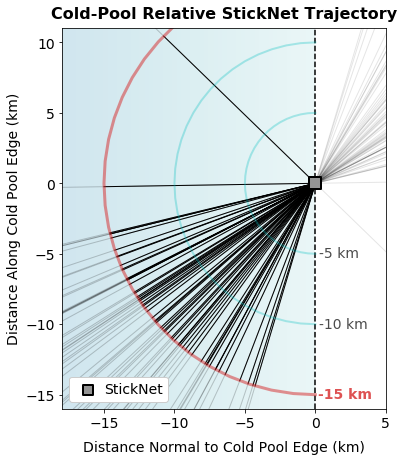

In [21]:
def plot_cprel(ax):
    
    
    #ax.set_title('Angles of Cold Pool Intersection', fontsize=16, y = 1.01, weight='bold')
    ax.set_title('Cold-Pool Relative StickNet Trajectory', fontsize=16, y = 1.01, weight='bold')
    
    #ax.scatter(0,0, marker = '+', s=(18**2), linewidth=6, color='k', zorder=30)
    ax.scatter(0,0, marker = 's', s=(12**2), linewidth=2, color='#949494', zorder=30, label='StickNet',
              edgecolor='k')


    for ID in sns.index:
        SN = sns.loc[ID]

        a = np.deg2rad(SN['storm_ref_angle'])
        ua = np.deg2rad(SN['Ua'])
        va = np.deg2rad(SN['Va'])
        new_angle = np.arctan(va/ua) - a
        
        ax.plot([0, -30*np.cos(new_angle)], [0,-30*(np.sin(new_angle))], color='k', 
                linewidth=1, alpha=0.2)
        ax.plot([0, 30*np.cos(new_angle)], [0,30*(np.sin(new_angle))], color='k', 
                linewidth=1, alpha=0.1)

        ax.plot([0, -15*np.cos(new_angle)], [0,-15*(np.sin(new_angle))], color='k', 
                linewidth=1, alpha=0.99) #'#25434d'

    # Location of Cold Pool
    ax.axvline(0, color='k', linestyle='--')
#     ax.text(0,7, 'Inferred Cold\nPool Edge', fontsize=15, horizontalalignment='center',verticalalignment='center',
#              bbox=dict(facecolor='w', edgecolor='w', pad=0))

    # Range Rings
    for R in [5,10,15]:
        x,y = get_circle(np.arange(np.pi/2,2*np.pi + np.pi/30 -np.pi/2, np.pi/30), R)
        c = 'c'; lw=2; a=0.3
        if R==15:
            c='C3'; lw=3; a=0.5
        ax.plot(x,y, color=c, alpha=a, linewidth=lw)



    ax.text(2.1,-15, '-15 km', alpha=0.8, weight='bold',color='C3',horizontalalignment='center',verticalalignment='center', fontsize=14, \
             bbox=dict(facecolor='w', edgecolor='w', pad=0))
    ax.text(2, -10, '-10 km', alpha=0.7, horizontalalignment='center',verticalalignment='center', fontsize=14, \
             bbox=dict(facecolor='w', edgecolor='w', pad=0))
    ax.text(1.7, -5,  '-5 km',alpha=0.7,  horizontalalignment='center',verticalalignment='center', fontsize=14, \
             bbox=dict(facecolor='w', edgecolor='w', pad=0))


    ax.set_xlim(-18,5)
    ax.set_ylim(-16,11)
    ax.set_xlabel('Distance Normal to Cold Pool Edge (km)', labelpad=10)
    ax.set_ylabel('Distance Along Cold Pool Edge (km)')

    # add cold pool 
    xs = np.arange(-25,.1,.1)
    ys =  np.arange(-18,15.1,.100)
    zs = [[x for x in xs] for y in ys]
    ax.contourf(xs, ys, zs,levels=xs, colors=cmo.ice(np.linspace(.6,.9, len(xs))),alpha=0.3 );

    ax.legend(loc=3, fontsize=14, framealpha=1, handletextpad=.11, markerscale=.8);
    
fig = plt.figure(figsize(7,7))
ax = fig.add_subplot(111, aspect='equal')
    
plot_cprel(ax)

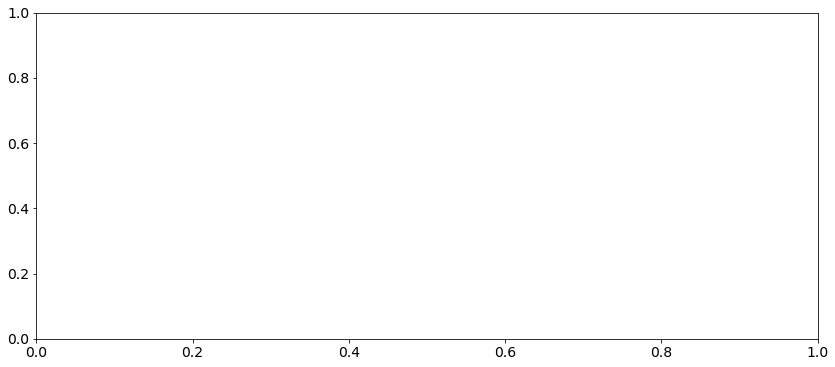

In [42]:
fig = figure(figsize=(14,6))
ax = plt.gca()
variable = 'TE'

tv_color = '#30749c'#'#3d6473'#'#315969' #'#0057b3'
te_color = '#67b05b'
color = te_color

def plot_traces(variable, ax, color):
    for i in sns.index:
        if np.isnan(sns.loc[i]['Ua']) != True:
            # unpack data
            snid = sns.loc[i]['ID']
            toa = pd.to_datetime(sns.loc[i]['TOA'])
            date = sns.loc[i]['date']

            met = var_dist_rel(sns.loc[i], variable)
            met = met.resample('10S').mean()
            
            
            
            x = -1*met['dist']/1000 # get into km
            def_dist=findnearest(x, -15)+1
            start_dist=findnearest(x,0)+1
            
            ax.plot(x[:start_dist], met['var'][:start_dist], color=color, alpha=0.1)
            
            ax.plot(x[start_dist-1:def_dist], met['var'][start_dist-1:def_dist], color=color, alpha=0.9)
            
            ax.plot(x[def_dist-1:], met['var'][def_dist-1:], color=color, alpha=0.3)
            ax.grid(linestyle=':')


    # plot current toa
    ax.axvline(0,color='k', linestyle='--')
    ax.axvline([-5], color='c', linewidth=2, alpha=0.2)
    ax.axvline([-10],color='c', linewidth=2, alpha=0.2)
    ax.axvline(-15, color='C3', linestyle='-', linewidth=3, alpha=0.4)
    ax.set_ylabel('K')

    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    ax.set_xlim(5,-20)



#plt.savefig('{}{}_{}.png'.format(savedir, date, snid), bbox_inches='tight')
# ax.invert_xaxis()
# plot_traces(variable, ax, color)

In [8]:
import matplotlib.gridspec as gridspec
from cmocean import cm as cmo

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', titlesize=16, labelsize=14)

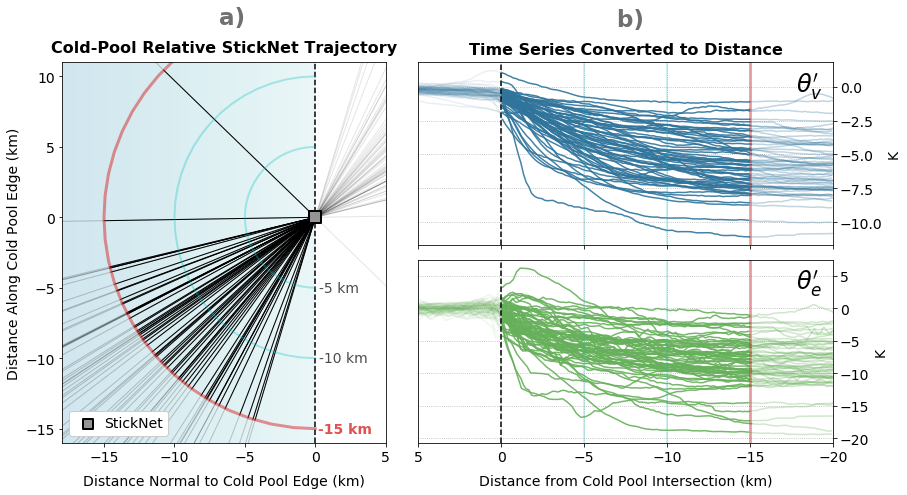

In [43]:
fig = plt.figure(figsize=(12,7))

# polar plot
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.07, right=0.48)
ax1=plt.subplot(gs1[0], aspect='equal')

# theta traces
gs2 = gridspec.GridSpec(2,1)
gs2.update(left=0.50, right=0.98, wspace=0.05, hspace=0.08)
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1], sharex=ax2)
ax2.invert_xaxis()
ax3.invert_xaxis()

plot_cprel(ax1)
plot_traces('TV', ax2, tv_color)
plot_traces('TE', ax3, te_color)

plt.setp(ax2.get_xticklabels(), visible=False);
ax3.set_xlabel('Distance from Cold Pool Intersection (km)', labelpad=10)
ax2.set_title('Time Series Converted to Distance', weight='bold', y=1.01)

ax2.text(0.91, 0.84, r'${\theta_v^{\prime}}$', fontsize=24, transform=ax2.transAxes);
ax3.text(0.91, 0.84, r'${\theta_e^{\prime}}$', fontsize=24, transform=ax3.transAxes);

ax1.text(0.46, 1.1, ' a)', fontsize=23, color='#6f7070',weight='bold', transform=ax1.transAxes);
ax2.text(0.46, 1.2, ' b)', fontsize=23, color='#6f7070',weight='bold', transform=ax2.transAxes);
save_dir = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/PubPlots/'
plt.savefig('{0}DeficitMethodDefense.png'.format(save_dir), bbox_inches = 'tight', format='png', dpi=300);

# Base state analyses

In [31]:
BIAS = pd.read_csv('/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/Bias_2017.txt', 
                   index_col=[0], delim_whitespace=True)
BIAS.index =['0{}A'.format(b) for b in BIAS.index]


def get_BS_Magnitude(SN, myvar):
    def_dist = 15*1000 # 10 km, 10,000 m
    def_dist2 = 10*1000 # 8 km 

    PROBE = SN['ID']
    starttime = pd.to_datetime(SN['TOA']) - dt.timedelta(minutes=30)
    met = get_1hz(SN['date'], PROBE[0:5], starttime, 30) # pull 30 mins, should be more than enough 

    u = SN['Ua']
    v = SN['Va']
    storm_speed = np.sqrt(u**2 + v**2)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled
    dist = abs(dist-dist[-1]) # distance going back in time starting at toa

    start = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0] # find where dist closest to 15
    end = np.where(abs(dist-def_dist2) == abs(dist-def_dist2).min())[0][0] # find where dist closest to 10
    change = np.nan
    
    #correction for short starts
    deldist = (def_dist-def_dist2) # delta distance from specified start and end distances
    if (end - start) < (deldist/storm_speed - 10) : # see if you have correct number of points
        start = 0
        ndist = storm_speed * delta_time
        end = np.where(abs(ndist-deldist) == abs(ndist-deldist).min())[0][0] # find 5 km from where data starts
        change = (ndist-ndist[-1])[0]
    
    if PROBE not in ['0218A','0219A','0220A', '0221A', '0222A','0223A','0224A']:
        T = met['T'] - BIAS.loc[PROBE]['T']
        RH = met['RH'] - BIAS.loc[PROBE]['RH']
        P = met['P'] - BIAS.loc[PROBE]['P']
    else:
        T = met['T']; RH=met['RH']; P = met['P']
    dewp = calc_dewpoint(T,RH)
    if myvar == 'TV':
        var = calc_thetav(T, dewp, P)
    if myvar == 'TE':
        var = calc_thetae(T, dewp, P)

    bs = np.mean(var[start:end])
    return bs #met.index[start], met.index[end], change #<- use these when making methods plots


def get_BS_Tdd(SN):
    def_dist = 15*1000 # 10 km, 10,000 m
    def_dist2 = 10*1000 # 8 km 

    PROBE = SN['ID']
    starttime = pd.to_datetime(SN['TOA']) - dt.timedelta(minutes=30)
    met = get_1hz(SN['date'], PROBE[0:5], starttime, 30) # pull 30 mins, should be more than enough 

    u = SN['Ua']
    v = SN['Va']
    storm_speed = np.sqrt(u**2 + v**2)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled
    dist = abs(dist-dist[-1]) # distance going back in time starting at toa

    start = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0] # find where dist closest to 15
    end = np.where(abs(dist-def_dist2) == abs(dist-def_dist2).min())[0][0] # find where dist closest to 10
    change = np.nan
    
    #correction for short starts
    deldist = (def_dist-def_dist2) # delta distance from specified start and end distances
    if (end - start) < (deldist/storm_speed - 10) : # see if you have correct number of points
        start = 0
        ndist = storm_speed * delta_time
        end = np.where(abs(ndist-deldist) == abs(ndist-deldist).min())[0][0] # find 5 km from where data starts
        change = (ndist-ndist[-1])[0]
   
    T = met['T']; RH=met['RH']; P = met['P']
    dewp = calc_dewpoint(T,RH)
   
    Tdd = T - dewp

    bs = np.mean(Tdd[start:end])
    return bs #met.index[start], met.index[end], 

def get_def_Magnitdue(SN, myvar, def_dist=15*1000):
    ''' def_dist is the distance in km that the deficit is considered.
    default is 10km'''
    PROBE = SN['ID']
    starttime = pd.to_datetime(SN['TOA'])
    met = get_1hz(SN['date'], SN['ID'][0:5], starttime, 30) # pull 30 mins, should be more than enough 

    u = SN['Ua']
    v = SN['Va']
    storm_speed = np.sqrt(u**2 + v**2)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled

    endtime = starttime + dt.timedelta(seconds=599) 

    # find where distance array is closest to 10km
    end = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0]

    
    if PROBE not in ['0218A','0219A','0220A', '0221A', '0222A','0223A','0224A']:
        T = met['T'] - BIAS.loc[PROBE]['T']
        RH = met['RH'] - BIAS.loc[PROBE]['RH']
        P = met['P'] - BIAS.loc[PROBE]['P']
    else:
        T = met['T']; RH=met['RH']; P = met['P']
        
    dewp = calc_dewpoint(T,RH)
    
    if myvar == 'TV':
        var = calc_thetav(T, dewp, P)
    if myvar == 'TE':
        var = calc_thetae(T, dewp, P)
        
        
    if SN['ID'] == '0222A': # fix for weird RH spikes
        if myvar == 'TE':
            RH = drop_badRH(met['RH'].copy())
            dewp = calc_dewpoint(met['T'],RH)
            var = calc_thetae(met['T'], dewp, met['P'])
        
    # drop one bad data point for 0222A  
#     if (starttime.strftime('%Y%m%d') == '20170430') & (PROBE == '0222A'):
#         thetae[thetae == thetae.min()] = np.nan  # drop the one wrong data point
#         thetav[thetav == thetav.min()] = np.nan
   
#     if SN['ID'] == '0222A': # fix for weird RH spikes
#         if myvar == 'TE':
#             RH = drop_badRH(met['RH'].copy())
#             dewp = calc_dewpoint(met['T'],RH)
#             var = calc_thetae(met['T'], dewp, met['P'])
            
    minval = np.nanmin(var.iloc[0:end+1])
    return  minval #- bs#met.index[0], met.index[end]# <- use these when making methods plots#minval - bs#

In [34]:
sns

date      ID  N_ID       Lats       Lons       mode type  \
0   20160331  0215A1  SSJH  35.038000 -87.471900  supercell    R   
1   20160331  0215A2  SSJH  35.038000 -87.471900  supercell    R   
2   20160331   0217A   NaN  35.015450 -87.671650  supercell    R   
3   20160331   0218A   NaN  34.968474 -87.669926  supercell    R   
4   20160331   0220A   NaN  35.151446 -87.744289  supercell    R   
5   20160331   0221A   NaN  35.052518 -87.680796  supercell    R   
6   20160331   0222A   NaN  35.084061 -87.719905  supercell    R   
7   20160430   0101A  SDTR  34.617600 -87.101400  supercell    R   
8   20170301   0103A   NaN  34.378112 -86.912166  supercell    R   
9   20170301   0109A   NaN  34.313122 -86.900077  supercell    R   
10  20170301   0217A  SDTR  34.617600 -87.101400  supercell    R   
11  20170310   0102A  SHYL  34.295900 -87.587100     linear   NR   
12  20170310   0103A  SCMT  34.855100 -86.001700     linear   NR   
13  20170310   0104A  SLYN  35.339100 -87.032400     linear    R   
14  20170310   0105A  SSBR  34.622400 -86.080000     linear   NR   
15  20170310   0107A  SCLM  34.194390 -86.798250     linear   NR   
16  20170310   0108A  SPBG  35.323600 -86.634700     linear    T   
17  20170310   0109A  SLBG  35.304500 -87.518500     linear   NR   
18  20170310   0110A  SDGS  34.163200 -86.334100     linear   NR   
19  20170310   0111A  SLYS  34.550400 -86.558200     linear   NR   
20  20170310   0112A  SLGN  34.725400 -87.462500     linear   NR   
21  20170310   0213A  SHLG  34.901600 -86.538600     linear   NR   
22  20170310   0214A  SEMT  34.930900 -86.976400     linear   NR   
23  20170310   0215A  SSJH  35.038000 -87.471900     linear   NR   
24  20170310   0216A  STLM  35.371900 -86.099800     linear    T   
25  20170310   0217A  SDTR  34.617600 -87.101400     linear   NR   
26  20170321   0103A  SCMT  34.855100 -86.001700     linear   NR   
27  20170321   0104A  SLYN  35.339100 -87.032400     linear    R   
28  20170321   0105A  SSBR  34.622400 -86.080000     linear   NR   
29  20170321   0107A  SCLM  34.194390 -86.798250     linear   NR   
..       ...     ...   ...        ...        ...        ...  ...   
44  20170327   0217A  SDTR  34.617600 -87.101400      mixed    R   
45  20170327   0222A   NaN  34.545342 -87.308107      mixed    R   
46  20170430   0102A  SHYL  34.295900 -87.587100     linear    R   
47  20170430   0103A  SCMT  34.855100 -86.001700     linear   NR   
48  20170430   0104A  SLYN  35.339100 -87.032400     linear   NR   
49  20170430   0105A  SSBR  34.622400 -86.080000     linear   NR   
50  20170430   0106A  SADN  34.214900 -87.161900     linear    R   
51  20170430   0107A  SCLM  34.194390 -86.798250     linear    T   
52  20170430   0108A  SPBG  35.323600 -86.634700     linear   NR   
53  20170430   0109A  SLBG  35.304500 -87.518500     linear   NR   
54  20170430   0110A  SDGS  34.163200 -86.334100     linear   NR   
55  20170430   0111A  SLYS  34.550400 -86.558200     linear    R   
56  20170430   0112A  SLGN  34.725400 -87.462500     linear    R   
57  20170430   0213A  SHLG  34.901600 -86.538600     linear   NR   
58  20170430   0214A  SEMT  34.930900 -86.976400     linear    R   
59  20170430   0215A  SSJH  35.038000 -87.471900     linear   NR   
60  20170430   0216A  STLM  35.371900 -86.099800     linear   NR   
61  20170430   0217A  SDTR  34.617600 -87.101400     linear    R   
62  20170430   0218A   NaN  34.448162 -87.219750     linear    R   
63  20170430   0219A   NaN  34.394485 -87.120229     linear   NR   
64  20170430   0220A   NaN  34.639214 -87.500392     linear    R   
65  20170430   0221A   NaN  34.523322 -87.296503     linear    R   
66  20170430   0222A   NaN  34.472091 -87.267640     linear    R   
67  20170430   0224A   NaN  34.420291 -87.169020     linear   NR   
68  20170422   0102A  SHYL  34.295900 -87.587100  supercell    R   
69  20170422   0103A  SCMT  34.855100 -86.001700  supercell    T   
70  20170422   0106A  SADN  34.214900 -87.161900  supercell    T

In [33]:
# analysis to appease Matt Parker
sns['Tdd_BS'] = np.nan
for SN in sns.index:
    if np.isnan(sns.loc[SN]['Ua']) == False:
     
        sns.loc[SN,'Tdd_BS'] = np.round(get_BS_Tdd(sns.loc[SN]),2)
        
sns.loc[1, 'Tdd_BS'] = sns.loc[0, 'Tdd_BS'] # set 0215A2 to the bs value for 0215A1

In [25]:
# add in base state information for review analysis - 10/23/2020
sns['TE_BS'] = np.nan
sns['TV_BS'] = np.nan

for SN in sns.index:
    if np.isnan(sns.loc[SN]['Ua']) == False:
        if str(sns.loc[SN]['date'])[0:4] == '2017':
            sns.loc[SN,'TE_BS'] = np.round(get_BS_Magnitude(sns.loc[SN], 'TE'),2)
            sns.loc[SN,'TV_BS'] = np.round(get_BS_Magnitude(sns.loc[SN], 'TV'),2)

In [39]:
event = sns[sns['date']==20170310]
event.index = event['ID']
event['te_bs'] = np.nan
event['tv_bs'] = np.nan
for SN in event.index:
    event.loc[SN,'te_bs'] = get_BS_Magnitude(event.loc[SN], 'TE')
    event.loc[SN,'tv_bs'] = get_BS_Magnitude(event.loc[SN], 'TV')

lats =        event['Lats'].values
lons =        event['Lons'].values
te_bs=        event['te_bs'].values
tv_bs=        event['tv_bs'].values

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set 

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [91]:

'hi' not in ['hi']

False

In [36]:
from scipy.interpolate import griddata
from matplotlib.dates import date2num, num2date, HourLocator,DateFormatter,MinuteLocator
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
from WarningPoly import get_ww_fordate, plot_warnings
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import pickle
from collections import OrderedDict
from metpy import  interpolate

# Set up our projection
crs = ccrs.PlateCarree()
globe = ccrs.Globe(datum='WGS84',ellipse='sphere')

# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')

llcrnrlon=-87.7
llcrnrlat=34.1
urcrnrlon=-85.9
urcrnrlat=35.5

west_lon, east_lon = -87.7, -85.9
north_lat, south_lat=35.55, 34.1

#lon_add, lat_add
LL = (west_lon),(north_lat)
UR = (east_lon ),(south_lat)
LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3, fontsize=12):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    
    edited by Jessie. Found on GitHub - https://github.com/SciTools/cartopy/issues/490
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    # the edge is the black lines in between and extending on the edges of the white and gray parts
    # sbx is the center. length * 500 == half the length
    
    # NOTE: in x-direction, ADDING a value moves it right, SUBTRACTING a value moves it left
    
    edge = 500
    bar_xs = [sbx - length * 500 - edge, sbx + length * 500 +edge]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth+4,solid_capstyle="butt")  # background
    
    #add colors - 4 colors
    x1, x2, x3, x4, x5 = sbx-length*500, sbx -length*250, sbx, sbx+length*250, sbx+length*500
    ax.plot([x1,x2-edge/2], [sby, sby], transform=tmc, color='w', linewidth=linewidth,solid_capstyle="butt")
    ax.plot([x2+edge/2,x3-edge/2] ,[sby, sby], transform=tmc, color='gray', linewidth=linewidth,solid_capstyle="butt")
    ax.plot([x3+edge/2,x4-edge/2] ,[sby, sby], transform=tmc, color='w', linewidth=linewidth,solid_capstyle="butt")
    ax.plot([x4+edge/2,x5] ,[sby, sby], transform=tmc, color='gray', linewidth=linewidth,solid_capstyle="butt")
    
    # add "km", center point, and end point
    y_lift = linewidth*10
    ax.text(x3, sby+length*y_lift , str(round(2 * length / 4)), transform=tmc,
                    horizontalalignment='center', verticalalignment='bottom',
                    color='k', fontsize=fontsize)
    ax.text(x5-length*50, sby+length*y_lift , str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color='k', fontsize=fontsize)
    ax.text(x1+length*90, sby+length*y_lift , 'km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color='k', fontsize=fontsize)


### 20170310

In [ ]:
event = sns[sns['date']==20170310]
event.index = event['ID']
event['te_bs'] = np.nan
event['tv_bs'] = np.nan
for SN in event.index:
    event.loc[SN,'te_bs'] = get_BS_Magnitude(event.loc[SN], 'TE')
    event.loc[SN,'tv_bs'] = get_BS_Magnitude(event.loc[SN], 'TV')

lats =        event['Lats'].values
lons =        event['Lons'].values
te_bs=        event['te_bs'].values
tv_bs=        event['tv_bs'].values

In [49]:
def rgb(hexcol):
    return matplotlib.colors.to_rgba(hexcol)

def plot_options(var):
    '''options include all named variables '''
    
    if var == 'te_deficits':
        mycmap = cmocean.cm.deep_r
        levels = np.arange(-19.5, -7.2, .5)
        clabel = 'K'
        title = r'30-min ${\theta_e}$ Deficits'
          
    elif var == 'tv_deficits':
        mycmap = cmocean.cm.tempo_r
        levels = np.arange(-10, -1.75, .25)
        clabel = 'K'
        title = r'30-min ${\theta_v}$ Deficits'
    
    elif var == 'dTVdn':
        colors = [rgb('#ffffff'),rgb('#aad5e2'),rgb('#3589a5'),rgb('#072f3d')][::-1]
        n_bin = 50
        cmap_name = 'my_list'
        mycmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        #mycmap=cmocean.cm.speed_r
        levels = np.arange(-2.1, -0.1, 0.1)
        clabel = r'K km${^{-1}}$'
        title = r'Maximum 3-min ${\theta_v}$ Change'
        
    elif var == 'te_bs':
        colors = [cm.YlGn(0.2),cm.YlGn(0.8) ]
        n_bin = 12
        cmap_name = 'my_list'
        mycmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        levels = None
        levels = np.arange(319.5,323.5, .5)
        clabel = 'K'
        title = r'Base State ${\theta_e}$'
        
    elif var == 'tv_bs':
        colors = [rgb('#fff3b7'), rgb('#af4e3f')]
        n_bin = 12
        cmap_name = 'my_list'
        mycmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        levels = None
        levels = np.arange(292,297, .25)
        clabel = 'K'
        title = r'Base State ${\theta_v}$'
        
    levels = levels
    cbar_label = clabel
    return mycmap, title, levels, cbar_label
    
    
poly = pickle.load(open('20170310_TorPoly.p', 'rb'))

In [48]:
np.max(tv_bs)

296.7184312216001

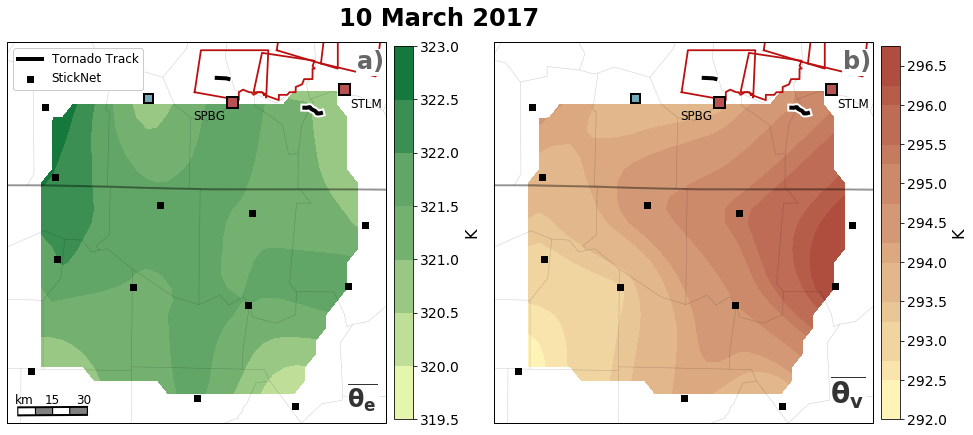

In [57]:
fig, axes = plt.subplots(1,2, figsize=(16, 7), subplot_kw={'projection': crs})

for ax in axes.flatten():
    ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.1, linewidth=0.5) # 20m, 5m 500k sizes from large to small
                                                        # use 20m for testing, and 500k for final plots

    ax.scatter(lons, lats, marker='s', color='k', transform=crs, label='StickNet')
    ax.set_aspect('auto')
    plot_warnings(poly, ax, linewidth = 1.8, color='#bc1010', label=None)

    for probe in event.index:
        lon, lat = event.loc[probe]['Lons'],event.loc[probe]['Lats']
        if probe == '0104A':
            ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
                markersize = 4, markeredgewidth=7)
            ax.plot(lon,lat, marker = 's', color = '#74a9b8', linewidth=0.0, 
                markersize = 4, markeredgewidth=3)

        if (probe == '0108A') | (probe == '0216A'):
            ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
                markersize = 6, markeredgewidth=7)
            ax.plot(lon,lat, marker = 's', color = '#b85151', linewidth=0.0, 
                markersize = 6, markeredgewidth=3)

    # plot tornado tracks
    tortrack = pickle.load(open('20170310_TorTrack.p', 'rb'))
    for track in tortrack.index:
        ax.plot(tortrack.iloc[track]['lons'],tortrack.iloc[track]['lats'], 
            color = 'w', linewidth=8)
        ax.plot(tortrack.iloc[track]['lons'],tortrack.iloc[track]['lats'], 
            color = 'k', linewidth=4, label='Tornado Track')
#             ax.plot(tortrack.iloc[track]['lons'],tortrack.iloc[track]['lats'], 
#                 color = '#b85151', linewidth=2, label='Tor Track')

        

# for interpolation and plotting  
gxx = np.arange(np.min(lons), np.max(lons)+0.05, 0.05)
gyy = np.arange(np.min(lats), np.max(lats)+0.05, 0.05)
gx, gy = np.meshgrid(gxx, gyy)
             
        
# THETA E
var =te_bs
mycmap, mytitle, levels, cbar_label = plot_options('te_bs')
#gx,gy,img1 = interpolate(np.asarray(lons),np.asarray(lats),np.asarray(var),interp_type='natural_neighbor',hres=.05)
img1 = interpolate.natural_neighbor_to_grid(np.asarray(lons),np.asarray(lats),np.asarray(var), gx, gy)

grid = axes[0].contourf(gx,gy,img1,cmap=mycmap, levels=levels )
axes[0].scatter(lons, lats, marker='s', color='k')

#cbar must be last, or fraction call somehow messes everything up
cbar = plt.colorbar(grid, ax=axes[0], fraction=0.046, pad=0.02)
cbar.set_label(cbar_label, fontsize = 16)
cbar.ax.tick_params(labelsize=14) 

# scale bar
scale_bar(axes[0], length=30, location=(0.12, 0.03), linewidth=6, fontsize=12)

# THETA V
var =tv_bs
mycmap, mytitle, levels, cbar_label = plot_options('tv_bs')
#gx,gy,img1 = interpolate(np.asarray(lons),np.asarray(lats),np.asarray(var),interp_type='natural_neighbor',hres=.05)
img1 = interpolate.natural_neighbor_to_grid(np.asarray(lons),np.asarray(lats),np.asarray(var), gx, gy)

grid = axes[1].contourf(gx,gy,img1,cmap=mycmap, levels=levels )
axes[1].scatter(lons, lats, marker='s', color='k')

#cbar must be last, or fraction call somehow messes everything up
cbar = plt.colorbar(grid, ax=axes[1], fraction=0.046, pad=0.02)
cbar.set_label(cbar_label, fontsize = 16)
cbar.ax.tick_params(labelsize=14)

# legend
handles, labels =axes[0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys(),fontsize=12, loc=2, framealpha=1)


# add plot type and plot label for publication
plot_labels = ['a)', 'b)']#, 'c)', 'd)']
plot_types = [r'$\mathbf{\overline{\theta_e}}$', 
              r'$\mathbf{\overline{\theta_v}}$']

plat, plon = event.loc['0108A']['Lats'],event.loc['0108A']['Lons']
plat2, plon2 = event.loc['0216A']['Lats'],event.loc['0216A']['Lons']

i=0
for ax in axes.flatten():
    
    # label important SN
    ax.text(plon-0.18, plat-0.07,'SPBG', color='k', fontsize=12)
    ax.text(plon2+.03, plat2-0.07,'STLM', color='k', fontsize=12)
    
    ax.text(-85.91,35.45,plot_labels[i], fontsize=24, color='k', alpha=0.6, weight='bold', ha='right',
           bbox=dict(facecolor='w', edgecolor='w', pad=1))
    if i ==1: # grad tv
        ax.text(-85.94,34.17,plot_types[i], fontsize=28, color='k', ha='right',alpha=0.8, 
               bbox=dict(facecolor='w',edgecolor='w', pad=0))
    else:
        ax.text(-85.94,34.155,plot_types[i], fontsize=24, color='k', ha='right',alpha=0.8, weight='bold',
               bbox=dict(facecolor='w', edgecolor='w', pad=0))
    i+=1
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.suptitle('10 March 2017', fontsize=24,weight='bold', y=0.95)

# file_dir = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/Pub_Figures/'
# plt.savefig('{0}10MarchContouredFourPanel.png'.format(save_dir), bbox_inches = 'tight', format='png', dpi=300);
plt.show()

### 20170430

In [135]:
event = sns[(sns['date']==20170430)]
#event = event.iloc[0:16]
event.index = event['ID']
event['te_bs'] = np.nan
event['tv_bs'] = np.nan
 
for SN in event.index:
    event.loc[SN,'te_bs'] = get_BS_Magnitude(event.loc[SN], 'TE')
    event.loc[SN,'tv_bs'] = get_BS_Magnitude(event.loc[SN], 'TV')
#     event.loc[SN,'TEdef_corrected'] = get_def_Magnitdue(event.loc[SN], 'TE')
#     event.loc[SN,'TVdef_corrected'] = get_def_Magnitdue(event.loc[SN], 'TV')

lats =        event['Lats'].values
lons =        event['Lons'].values
te_bs=        event['te_bs'].values
tv_bs=        event['tv_bs'].values


event['TVdef_corrected'] = event['TV_dist'] + tv_bs
event['TEdef_corrected'] = event['TE_dist'] + te_bs

# te_cor = event['TEdef_corrected']
# tv_cor = event['TVdef_corrected']

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [141]:
te_cor = event['TEdef_corrected']
tv_cor = event['TVdef_corrected']

In [146]:
print(np.max(tv_cor)-np.min(tv_cor))
print(np.max(event['TV_dist'])-np.min(event['TV_dist']))

3.446073879971607
3.9399999999999995


In [143]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import cmocean

def rgb(hexcol):
    return matplotlib.colors.to_rgba(hexcol)

def plot_options(var):
    '''options include all named variables '''
    
    if var == 'te_deficits':
        mycmap = cmocean.cm.deep_r
        levels = np.arange(-13.5,-4,.5)
        clabel = 'K'
        title = r'10-min ${\theta_e}$ Deficits'
          
    elif var == 'tv_deficits':
        mycmap = cmocean.cm.tempo_r
        levels = np.arange(-8.75,-4.5,0.25)
        clabel = 'K'
        title = r'10-min ${\theta_v}$ Deficits'
        
    elif var == 'dTVdn':
        colors = [rgb('#ffffff'),rgb('#aad5e2'),rgb('#3589a5'),rgb('#072f3d')][::-1]
        n_bin = 50
        cmap_name = 'my_list'
        mycmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        levels = np.arange(-2.8,-0.7,.1)
        clabel = r'K km${^{-1}}$'
        title = r'Maximum 3-min ${\theta_v}$ Change'
        
    elif var == 'te_bs':
        colors = [cm.YlGn(0.2),cm.YlGn(0.8) ]
        n_bin = 12
        cmap_name = 'my_list'
        mycmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        levels = None
        levels = np.arange(336.5,341.5, .5)
        clabel = 'K'
        title = r'Base State ${\theta_e}$'
        
    elif var == 'tv_bs':
        colors = [rgb('#fff3b7'), rgb('#af4e3f')]
        n_bin = 12
        cmap_name = 'my_list'
        mycmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        levels = None
        levels = np.arange(301.25,304.5, .25)
        clabel = 'K'
        title = r'Base State ${\theta_v}$'
        
        
    if var == 'te_cor':
        mycmap = cmocean.cm.deep_r
        levels = np.arange(327,335.5,.5)
        clabel = 'K'
        title = r'10-min ${\theta_e}$ Deficits'
          
    elif var == 'tv_cor':
        mycmap = cmocean.cm.tempo_r
        levels = np.arange(294.5,298.25,0.25)
        clabel = 'K'
        title = r'10-min ${\theta_v}$ Deficits'

    return mycmap, title, levels, clabel
poly = pickle.load(open('20170430_TorPoly.p', 'rb'))

In [138]:
print(np.min(te_cor), np.max(te_cor))

327.3505326889193 334.56473970078497


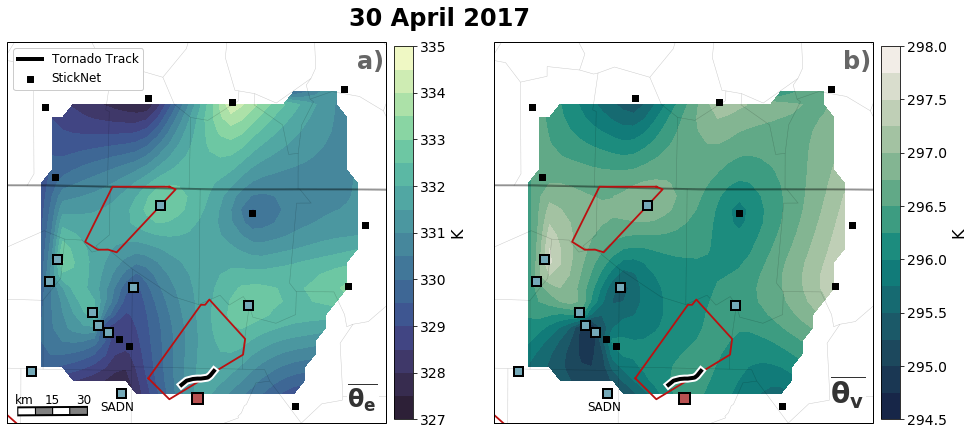

In [144]:
fig, axes = plt.subplots(1,2, figsize=(16, 7), subplot_kw={'projection': crs})

for ax in axes.flatten():
    ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.1, linewidth=0.5) # 20m, 5m 500k sizes from large to small
                                                        # use 20m for testing, and 500k for final plots

    ax.scatter(lons, lats, marker='s', color='k', transform=crs, label='StickNet')
    ax.set_aspect('auto')
    plot_warnings(poly, ax, linewidth = 1.8, color='#bc1010', label=None)

    for probe in event.index:
        if probe in ['0102A', '0106A', '0214A', '0111A', '0217A','0112A', '0220A','0221A','0222A','0218A']:
            ax.plot(event.loc[probe]['Lons'],event.loc[probe]['Lats'], marker = 's', color = 'k', linewidth=0.0, 
                markersize = 4, markeredgewidth=7)
            ax.plot(event.loc[probe]['Lons'],event.loc[probe]['Lats'], marker = 's', color = '#74a9b8', linewidth=0.0, 
                markersize = 4, markeredgewidth=3)

        if probe == '0107A':
            ax.plot(event.loc[probe]['Lons'],event.loc[probe]['Lats'], marker = 's', color = 'k', linewidth=0.0, 
                markersize = 6, markeredgewidth=7)
            ax.plot(event.loc[probe]['Lons'],event.loc[probe]['Lats'], marker = 's', color = '#b85151', linewidth=0.0, 
                markersize = 6, markeredgewidth=3)

    # plot tornado tracks
    tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
    for track in tortrack.index:
        ax.plot(tortrack.iloc[track]['lons'],tortrack.iloc[track]['lats'], 
            color = 'w', linewidth=8)
        ax.plot(tortrack.iloc[track]['lons'],tortrack.iloc[track]['lats'], 
            color = 'k', linewidth=4, label='Tornado Track')
#             ax.plot(tortrack.iloc[track]['lons'],tortrack.iloc[track]['lats'], 
#                 color = '#b85151', linewidth=2, label='Tor Track')

        

# for interpolation and plotting  
gxx = np.arange(np.min(lons), np.max(lons)+0.05, 0.05)
gyy = np.arange(np.min(lats), np.max(lats)+0.05, 0.05)
gx, gy = np.meshgrid(gxx, gyy)
             
        
# THETA E
var =te_cor
mycmap, mytitle, levels, cbar_label = plot_options('te_cor')
#gx,gy,img1 = interpolate(np.asarray(lons),np.asarray(lats),np.asarray(var),interp_type='natural_neighbor',hres=.05)
img1 = interpolate.natural_neighbor_to_grid(np.asarray(lons),np.asarray(lats),np.asarray(var), gx, gy)

grid = axes[0].contourf(gx,gy,img1,cmap=mycmap, levels=levels )
axes[0].scatter(lons, lats, marker='s', color='k')

#cbar must be last, or fraction call somehow messes everything up
cbar = plt.colorbar(grid, ax=axes[0], fraction=0.046, pad=0.02)
cbar.set_label(cbar_label, fontsize = 16)
cbar.ax.tick_params(labelsize=14) 

# scale bar
scale_bar(axes[0], length=30, location=(0.12, 0.03), linewidth=6, fontsize=12)

# THETA V
var =tv_cor
mycmap, mytitle, levels, cbar_label = plot_options('tv_cor')
#gx,gy,img1 = interpolate(np.asarray(lons),np.asarray(lats),np.asarray(var),interp_type='natural_neighbor',hres=.05)
img1 = interpolate.natural_neighbor_to_grid(np.asarray(lons),np.asarray(lats),np.asarray(var), gx, gy)

grid = axes[1].contourf(gx,gy,img1,cmap=mycmap, levels=levels )
axes[1].scatter(lons, lats, marker='s', color='k')

#cbar must be last, or fraction call somehow messes everything up
cbar = plt.colorbar(grid, ax=axes[1], fraction=0.046, pad=0.02)
cbar.set_label(cbar_label, fontsize = 16)
cbar.ax.tick_params(labelsize=14)

# legend
handles, labels =axes[0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys(),fontsize=12, loc=2, framealpha=1)


# add plot type and plot label for publication
plot_labels = ['a)', 'b)']#, 'c)', 'd)']
plot_types = [r'$\mathbf{\overline{\theta_e}}$', 
              r'$\mathbf{\overline{\theta_v}}$']

# add in label for SADN to aid in text discussion
plat, plon = event.loc['0106A']['Lats'],event.loc['0106A']['Lons']


i=0
for ax in axes.flatten():
    
    # label important SN
    ax.text(plon-0.095, plat-0.07,'SADN', color='k', fontsize=12)
    
    ax.text(-85.91,35.45,plot_labels[i], fontsize=24, color='k', alpha=0.6, weight='bold', ha='right',
           bbox=dict(facecolor='w', edgecolor='w', pad=1))
    if i ==1: # grad tv
        ax.text(-85.94,34.17,plot_types[i], fontsize=28, color='k', ha='right',alpha=0.8, 
               bbox=dict(facecolor='w',edgecolor='w', pad=0))
    else:
        ax.text(-85.94,34.155,plot_types[i], fontsize=24, color='k', ha='right',alpha=0.8, weight='bold',
               bbox=dict(facecolor='w', edgecolor='w', pad=0))
    i+=1
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.suptitle('30 April 2017', fontsize=24,weight='bold', y=0.95)

# file_dir = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/Pub_Figures/'
# plt.savefig('{0}10MarchContouredFourPanel.png'.format(save_dir), bbox_inches = 'tight', format='png', dpi=300);
plt.show()

In [148]:
d_20170430

date     ID  N_ID       Lats       Lons    mode type  \
ID                                                                
0102A  20170430  0102A  SHYL  34.295900 -87.587100  linear    R   
0103A  20170430  0103A  SCMT  34.855100 -86.001700  linear   NR   
0104A  20170430  0104A  SLYN  35.339100 -87.032400  linear   NR   
0105A  20170430  0105A  SSBR  34.622400 -86.080000  linear   NR   
0106A  20170430  0106A  SADN  34.214900 -87.161900  linear    R   
0107A  20170430  0107A  SCLM  34.194390 -86.798250  linear    T   
0108A  20170430  0108A  SPBG  35.323600 -86.634700  linear   NR   
0109A  20170430  0109A  SLBG  35.304500 -87.518500  linear   NR   
0110A  20170430  0110A  SDGS  34.163200 -86.334100  linear   NR   
0111A  20170430  0111A  SLYS  34.550400 -86.558200  linear    R   
0112A  20170430  0112A  SLGN  34.725400 -87.462500  linear    R   
0213A  20170430  0213A  SHLG  34.901600 -86.538600  linear   NR   
0214A  20170430  0214A  SEMT  34.930900 -86.976400  linear    R   
0215A  20170430  0215A  SSJH  35.038000 -87.471900  linear   NR   
0216A  20170430  0216A  STLM  35.371900 -86.099800  linear   NR   
0217A  20170430  0217A  SDTR  34.617600 -87.101400  linear    R   
0218A  20170430  0218A   NaN  34.448162 -87.219750  linear    R   
0219A  20170430  0219A   NaN  34.394485 -87.120229  linear   NR   
0220A  20170430  0220A   NaN  34.639214 -87.500392  linear    R   
0221A  20170430  0221A   NaN  34.523322 -87.296503  linear    R   
0222A  20170430  0222A   NaN  34.472091 -87.267640  linear    R   
0224A  20170430  0224A   NaN  34.420291 -87.169020  linear   NR   

                 TOA  storm_ref_angle    Ua  ...  Bsdist_mods  TE_dist  \
ID                                           ...                         
0102A  4/30/17 18:08             32.0  11.4  ...          NaN   -10.84   
0103A  4/30/17 20:42             25.0  10.1  ...          NaN    -5.62   
0104A  4/30/17 19:29             -1.0  12.4  ...          NaN    -9.80   
0105A  4/30/17 20:29             10.0  12.3  ...          NaN    -7.54   
0106A  4/30/17 18:47             32.0  10.8  ...          NaN   -12.81   
0107A  4/30/17 19:08             27.0  13.1  ...          NaN    -7.85   
0108A  4/30/17 20:01             36.0  12.3  ...          NaN    -4.79   
0109A  4/30/17 18:28            -10.0  11.4  ...          NaN    -8.75   
0110A  4/30/17 20:01              2.0  12.3  ...          NaN   -11.22   
0111A  4/30/17 19:43             29.0  10.7  ...          NaN    -7.44   
0112A  4/30/17 18:36              8.0  10.5  ...          NaN    -6.36   
0213A  4/30/17 19:55             19.0  11.0  ...          NaN   -10.38   
0214A  4/30/17 19:21             20.0  12.4  ...          NaN    -4.51   
0215A  4/30/17 18:33             -1.0  10.6  ...          NaN    -6.96   
0216A  4/30/17 20:47              7.0  12.6  ...          NaN    -7.81   
0217A  4/30/17 18:56              5.0  10.5  ...          NaN   -10.67   
0218A  4/30/17 18:38            -14.0  14.0  ...          NaN   -11.71   
0219A  4/30/17 18:51              6.0  10.5  ...          NaN   -11.11   
0220A  4/30/17 18:32             35.0  10.6  ...          NaN    -9.17   
0221A  4/30/17 18:37             30.0  14.0  ...          NaN    -7.94   
0222A  4/30/17 18:36             14.0  14.0  ...          NaN    -9.35   
0224A  4/30/17 18:46             17.0  14.4  ...          NaN    -9.17   

       TV_dist  dTVdn  storm_u_OLD  storm_v_OLD       te_bs       tv_bs  \
ID                                                                        
0102A    -5.94  -0.92         12.3          9.9  340.388727  301.760374   
0103A    -5.77  -1.72         12.3          9.9  336.794621  303.245740   
0104A    -7.23  -1.80         12.3          9.9  336.933127  302.404865   
0105A    -6.72  -2.10         12.3          9.9  340.755861  304.204968   
0106A    -8.16  -2.59         12.3          9.9  340.028157  303.077648   
0107A    -7.26  -2.19         12.3          9.9  339.605333  303.663151   
0108A    -5.52  -1.16    

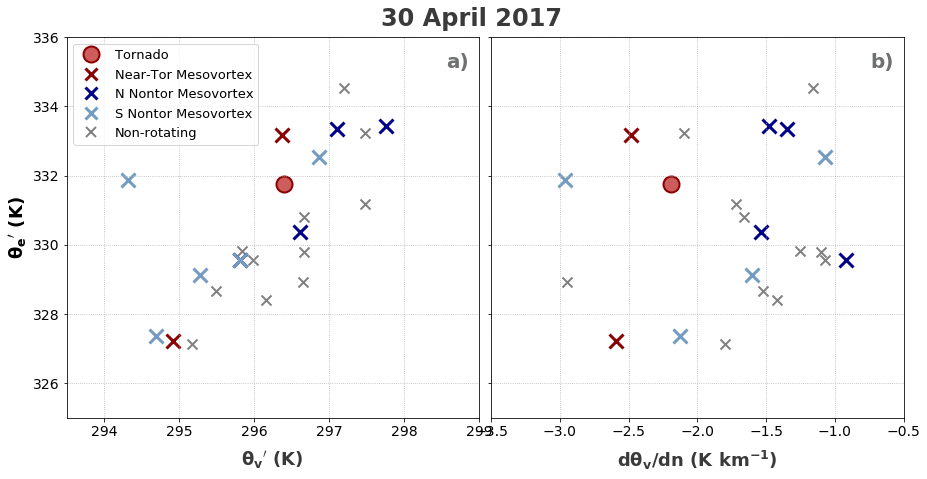

In [154]:
import matplotlib.lines as mlines
d_20170430 = event.copy()#[sns['date']==20170430]

d_20170430= d_20170430.rename(columns={"TVdef_corrected": "TV", "TEdef_corrected": "TE"})


ig, [ax,ax2] = plt.subplots(1,2, figsize=(15,7), sharey=True)
# ax = axes[0]
# ax2 = axes[1]

#plt.title(r'10-min ${\theta_v}$ and ${\theta_e}$ Deficits',fontsize=24, y = 1.01)
ax.set_xlabel(r'$\mathbf{{\theta_v}^\prime}$ (K)', fontsize=18, labelpad = 10, weight='bold', color='#3a3a3a')
ax.set_ylabel(r'$\mathbf{{\theta_e}^\prime}$ (K)', fontsize=18, weight='bold')
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)

nontorsize = (14**2)
nonwidth=3

dist_10 = (16*16)
dist_15 = (10*10)
time_15 = '#350507'
time_10 = 'darkred'
time_5 = 'indianred'


#N = 6, 7, 11
#S =  2, 12, 221, 222, 14 

tor = [d_20170430.loc[['0107A']]['TV'],\
     d_20170430.loc['0107A']['TE']]
S = [d_20170430.loc[['0106A', '0111A']]['TV'],\
     d_20170430.loc[['0106A', '0111A']]['TE']]
N = [d_20170430.loc[['0102A','0214A','0112A','0220A']]['TV'],\
     d_20170430.loc[['0102A','0214A','0112A','0220A']]['TE']]
N2 =[d_20170430.loc[['0102A', '0217A','0221A','0222A','0218A']]['TV'],\
     d_20170430.loc[['0102A', '0217A','0221A','0222A','0218A']]['TE']]
n2 = ['0102A', '0217A','0221A','0222A','0218A']


# 20170430
ax.scatter(d_20170430['TV'].loc[~d_20170430.index.isin(n2)]\
        ,d_20170430['TE'].loc[~d_20170430.index.isin(n2)], marker='x',color='gray', s=(10**2), linewidth=2)

ax.scatter(S[0],S[1], marker='x', s=nontorsize,color='darkred',linewidth=nonwidth)
ax.scatter(N[0],N[1], marker='x', s=nontorsize,color='darkblue',linewidth=nonwidth)
ax.scatter(N2[0],N2[1], marker='x', s=nontorsize,color='#749cc2',alpha=1,linewidth=nonwidth)
# keep 
ax.scatter(tor[0],tor[1],\
        s=dist_10, color=time_5, linewidth=2, edgecolors='darkred') #107

ax.grid(linestyle=':')



shapes = mlines.Line2D([],[], color = 'k', markersize=43,  marker = '$Feature Near Observation$',linewidth=0, label=r'')
non = mlines.Line2D([],[], color = 'gray', markersize=10, mew='2',marker = 'x',linewidth=0, label=r'Non-rotating')
Nnon = mlines.Line2D([],[], color = 'darkblue', markersize=12, mew='3', marker = 'x',linewidth=0, label=r'N Nontor Mesovortex')
Nnon2 = mlines.Line2D([],[], color = '#749cc2', alpha=1,markersize=12, mew='3', marker = 'x',linewidth=0, label=r'S Nontor Mesovortex')
Snon = mlines.Line2D([],[], color = 'darkred', markersize=12, mew='3', marker = 'x',linewidth=0, label=r'Near-Tor Mesovortex')
tor = mlines.Line2D([],[], color = 'indianred',  markersize = 16,mew='2',marker = 'o', linewidth = 0,mec = 'darkred', label='Tornado')
leg = ax.legend(handles = [tor,Snon, Nnon,Nnon2, non],
                 loc=2, fontsize=13)#,title='Feature Near Observation')
leg.get_title().set_fontsize('15') 




ax.set_facecolor('w')
ax.patch.set_visible(False)

###########################


ax2.set_xlabel(r'$\mathbf{d\theta_v/{dn}}$ (K km$\mathbf{^{-1}}$)', fontsize=18, labelpad = 10, color='#3a3a3a', weight='bold')
#plt.ylabel(r'${\theta_v}$ Deficit (K)', fontsize=18)
ax2.tick_params(axis='y',labelsize=14)
ax2.tick_params(axis='x',labelsize=14)


n2 = ['0102A', '0217A','0221aA','0222A','0218A']

tor = [d_20170430.loc[['0107A']]['dTVdn'],\
     d_20170430.loc['0107A']['TE']]


S = [d_20170430.loc[['0106A', '0111A']]['dTVdn'],\
     d_20170430.loc[['0106A', '0111A']]['TE']]

N = [d_20170430.loc[['0214A', '0217A','0112A','0220A','0221A','0222A','0218A']]['dTVdn'],\
     d_20170430.loc[['0214A', '0217A','0112A','0220A','0221A','0222A','0218A']]['TE']]
N = [d_20170430.loc[['0102A','0214A','0112A','0220A']]['dTVdn'],\
     d_20170430.loc[['0102A','0214A','0112A','0220A']]['TE']]

N2 =[d_20170430.loc[[ '0217A','0221A','0222A','0218A']]['dTVdn'],\
     d_20170430.loc[[ '0217A','0221A','0222A','0218A']]['TE']]

# 20170430
ax2.scatter(d_20170430['dTVdn'].loc[~d_20170430.index.isin(n2)],\
        d_20170430['TE'].loc[~d_20170430.index.isin(n2)], marker='x',color='gray', s=(10**2), linewidth=2)

ax2.scatter(S[0],S[1], marker='x', s=nontorsize,color='darkred',linewidth=nonwidth)
ax2.scatter(N[0],N[1], marker='x', s=nontorsize,color='darkblue',linewidth=nonwidth)
ax2.scatter(N2[0],N2[1], marker='x', s=nontorsize,color='#749cc2', alpha=1,linewidth=nonwidth)

#ax2.scatter(d_20170430.loc[['0109A']]['dTVdn'], d_20170430.loc[['0109A']]['TV'], color='orange')

# keep 
ax2.scatter(tor[0],tor[1],\
        s=dist_10, color=time_5, linewidth=2, edgecolors='darkred') #107

ax2.grid(linestyle=':')

ax.set_ylim(325,336);
ax.set_xlim(293.5, 299);

ax2.set_xlim(-3.5,-0.5);

ax2.set_facecolor('w')
ax2.patch.set_visible(False)

ax.text(0.92,0.92,'a)', fontsize=20, transform=ax.transAxes,color='#6f7070',
           weight= 'bold')
ax2.text(0.92,0.92,'b)', fontsize=20, transform=ax2.transAxes,color='#6f7070',
           weight= 'bold')
plt.subplots_adjust(wspace=.03)
plt.suptitle('30 April 2017', fontsize=24, weight='bold', color='#3a3a3a', y=.94)
#plt.savefig('{0}30AprilDefs.png'.format(save_dir), bbox_inches = 'tight', format='png', dpi=300);
plt.show()

### mess

Text(0, 0.5, 'N-S Distance from StickNet (km)')

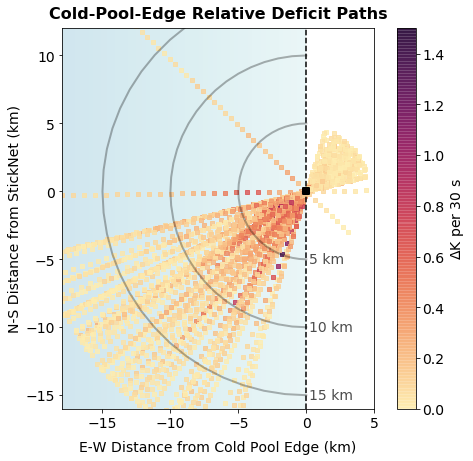

In [295]:
#def plot_grads(ax, VAR):
fig = plt.figure(figsize(8,7))
ax = fig.add_subplot(111, aspect='equal') 

VAR = 'TV'
    
ax.set_title('Cold-Pool-Edge Relative Deficit Paths', fontsize=16, y = 1.01, weight='bold')

#ax.scatter(0,0, marker = '+', s=(18**2), linewidth=6, color='k', zorder=30)
ax.scatter(0,0, marker = 's', s=(6**2), linewidth=2, color='k', zorder=30, label='StickNet')
# add cold pool 
xs = np.arange(-25,.1,.1)
ys =  np.arange(-18,15.1,.100)
zs = [[x for x in xs] for y in ys]
ax.contourf(xs, ys, zs,levels=xs, colors=cmo.ice(np.linspace(.6,.9, len(xs))),alpha=0.3 );

for ID in sns.index:
    SN = sns.loc[ID]

    a = np.deg2rad(SN['storm_ref_angle'])
    if np.isnan(a) != True:
        ua = np.deg2rad(SN['Ua'])
        va = np.deg2rad(SN['Va'])
        new_angle = np.arctan(va/ua) - a

        met = var_dist_rel(SN, VAR)
        met = met.resample('30s').mean()

        dist = -1*met['dist'][1:]/1000 # km

        vals = met['var']

        gradient = abs(vals.iloc[1:].values - vals.iloc[:len(vals)-1].values)

        im = plt.scatter(dist*np.cos(new_angle), dist*np.sin(new_angle), c=gradient, cmap=cmo.matter, marker='s',
                   vmin=0, vmax=1.5, s=(4**2), alpha=0.8)

plt.colorbar(im, ax=ax, label = r"${\Delta}$K per 30 s")
#     ax.plot([0, -30*np.cos(new_angle)], [0,-30*(np.sin(new_angle))], color='k', 
#             linewidth=1, alpha=0.2)

#     ax.plot([0, -15*np.cos(new_angle)], [0,-15*(np.sin(new_angle))], color='k', 
#             linewidth=1, alpha=0.99) #'#25434d'

# Location of Cold Pool
ax.axvline(0, color='k', linestyle='--')
#     ax.text(0,7, 'Inferred Cold\nPool Edge', fontsize=15, horizontalalignment='center',verticalalignment='center',
#              bbox=dict(facecolor='w', edgecolor='w', pad=0))

# Range Rings
for R in [5,10,15]:
    x,y = get_circle(np.arange(np.pi/2,2*np.pi + np.pi/30 -np.pi/2, np.pi/30), R)
    ax.plot(x,y, color='k', alpha=0.3, linewidth=2)



ax.text(1.8,-15, '15 km', alpha=0.7, horizontalalignment='center',verticalalignment='center', fontsize=14, \
         bbox=dict(facecolor='w', edgecolor='w', pad=0))
ax.text(1.8, -10, '10 km', alpha=0.7, horizontalalignment='center',verticalalignment='center', fontsize=14, \
         bbox=dict(facecolor='w', edgecolor='w', pad=0))
ax.text(1.5, -5,  '5 km',alpha=0.7,  horizontalalignment='center',verticalalignment='center', fontsize=14, \
         bbox=dict(facecolor='w', edgecolor='w', pad=0))


ax.set_xlim(-18,5)
ax.set_ylim(-16,12)
ax.set_xlabel('E-W Distance from Cold Pool Edge (km)', labelpad=10)
ax.set_ylabel('N-S Distance from StickNet (km)')


#ax.legend(loc=2, fontsize=14, framealpha=1, handletextpad=.11, markerscale=.8);
    

    
#plot_grads(ax, 'TV')

In [12]:
from functions import convert_wind

In [33]:
def distandwind(SN, pretoa=10*1000, posttoa=10*1000):
    ''' SN is the sticknet data
    pretoa is m before toa to start using data
    posttoa is m after toa to stop using data
    distance is distance in meters to calculated the max thetav change'''
    
    # check for empty files
    ref = SN['storm_ref_angle']
    if np.isnan(ref)!= True:
    
        snid = SN['ID']
        u = SN['Ua']
        v = SN['Va']
        storm_speed = np.sqrt(u**2 + v**2)
        date = SN['date']
        toa = pd.to_datetime(SN['TOA'])

        # grab time 15 minutes before toa and 30 minutes after, should be big enough buffer
        duration = 45 # note: found bug on 3/25/2020... duration was not set and was still 20(?). However,
                      # this does not change any of the values so we good
        met = get_1hz(date,snid[0:5], toa - dt.timedelta(minutes=15), 45)


        # create distance array based on correction angle
        delta_time = (met.index[:]-met.index[0]).seconds
        dist = storm_speed * delta_time
        theta_c = get_correction_angle(u,v,ref)
        new_dist = dist * np.cos(theta_c)

        # center new_dist on TOA, negative values are before TOA, postive are after
        toa_idx = np.where(met.index==toa)[0][0]
        new_dist = new_dist - new_dist[toa_idx]

        start_idx = findnearest(new_dist, -1*pretoa)
        end_idx = findnearest(new_dist, posttoa)


        new_dist = new_dist[start_idx: end_idx]
        u_wind, v_wind = convert_wind(met['WS'], met['WD'])
        
        dudx = np.gradient(u_wind)
        #dvdx = np.gradient(v_wind)
        
        convergence = -1*(dudx)


        return new_dist, convergence[start_idx:end_idx]

In [34]:
event = sns[sns['date']==20170430]

d, c = distandwind(event.iloc[0])

In [35]:
min(c)

-15.649625425421826

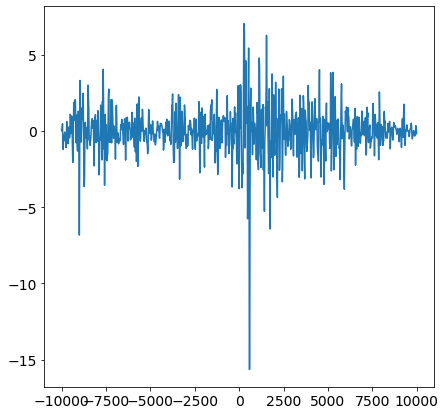

In [36]:
plt.plot(d, c)

In [5]:
def get_correction_angle(u, v, ref):
    theta_motion = np.rad2deg(np.arctan(v/u))
    if (theta_motion < 0) & (ref < 0):
        theta_correction = np.deg2rad(abs(ref) - abs(theta_motion)) 
    else:
        theta_correction = np.deg2rad(abs(ref - theta_motion))
  
    return theta_correction

def get_BSdist(SN, myvar):
    def_dist = 15*1000 # 10 km, 10,000 m
    def_dist2 = 10*1000 # 8 km 

    starttime = pd.to_datetime(SN['TOA']) - dt.timedelta(minutes=30)
    met = get_1hz(SN['date'], SN['ID'][0:5], starttime, 30) # pull 30 mins, should be more than enough 

    u = SN['Ua']
    v = SN['Va']
    storm_speed = np.sqrt(u**2 + v**2)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled
    dist = abs(dist-dist[-1]) # distance going back in time starting at toa

    start = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0] # find where dist closest to 15
    end = np.where(abs(dist-def_dist2) == abs(dist-def_dist2).min())[0][0] # find where dist closest to 10
    change = np.nan
    
    #correction for short starts
    deldist = (def_dist-def_dist2) # delta distance from specified start and end distances
    if (end - start) < (deldist/storm_speed - 10) : # see if you have correct number of points
        start = 0
        ndist = storm_speed * delta_time
        end = np.where(abs(ndist-deldist) == abs(ndist-deldist).min())[0][0] # find 5 km from where data starts
        change = (ndist-ndist[-1])[0]
    

    dewp = calc_dewpoint(met['T'],met['RH'])
    if myvar == 'TV':
        var = calc_thetav(met['T'], dewp, met['P'])
    if myvar == 'TE':
        var = calc_thetae(met['T'], dewp, met['P'])

    bs = np.mean(var[start:end])
    return bs #met.index[start], met.index[end], change #<- use these when making methods plots

def drop_badRH(RH):
    drh = 30
    bad_locs=[]
    for i, val in enumerate(RH[0:-drh]):
        std=np.std(RH[i:i+drh-1])
        mean = np.average(RH[i:i+drh-1])
        if (RH[i+drh] > mean+8 )| (RH[i+drh] < mean-8):
            bad_locs.append(i+drh)
    RH[bad_locs]=np.nan   
    return RH

def get_distdef_correctionAngle(SN, myvar, def_dist=15*1000):
    ''' def_dist is the distance in km that the deficit is considered.
    default is 10km'''

    starttime = pd.to_datetime(SN['TOA'])
    met = get_1hz(SN['date'], SN['ID'][0:5], starttime, 30) # pull 30 mins, should be more than enough 

    u = SN['Ua']
    v = SN['Va']
    storm_speed = np.sqrt(u**2 + v**2)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled
    
    ref= SN['storm_ref_angle']
    theta_c = get_correction_angle(u,v,ref)
    dist = dist * np.cos(theta_c)

    endtime = starttime + dt.timedelta(seconds=599) 

    # find where distance array is closest to 10km
    end = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0]

    dewp = calc_dewpoint(met['T'],met['RH'])
    if myvar == 'TV':
        var = calc_thetav(met['T'], dewp, met['P'])
    if myvar == 'TE':
        var = calc_thetae(met['T'], dewp, met['P'])

    bs = get_BSdist(SN, myvar)
    

    if SN['ID'] == '0215A2': # using 10-15 km basestate, with corrected TOAs
        fix_0215A2 = {'TE':331.6284883813534, 
                      'TV':297.9980389891804}
        bs = fix_0215A2[myvar]
        
    if SN['ID'] == '0222A': # fix for weird RH spikes
        if myvar == 'TE':
            RH = drop_badRH(met['RH'].copy())
            dewp = calc_dewpoint(met['T'],RH)
            var = calc_thetae(met['T'], dewp, met['P'])
            
    minval = np.min(var.iloc[0:end+1])
    return  minval - bs#met.index[0], met.index[end]# <- use these when making methods plots#minval - bs#

In [21]:
SN = sns.iloc[45]
myvar='TE'
def_dist=15*1000

starttime = pd.to_datetime(SN['TOA'])
met = get_1hz(SN['date'], SN['ID'][0:5], starttime, 30) # pull 30 mins, should be more than enough 

u = SN['Ua']
v = SN['Va']
storm_speed = np.sqrt(u**2 + v**2)
delta_time = (met.index[:]-met.index[0]).seconds
dist = storm_speed * delta_time # distance traveled

ref= SN['storm_ref_angle']
theta_c = get_correction_angle(u,v,ref)
dist = dist * np.cos(theta_c)

endtime = starttime + dt.timedelta(seconds=599) 

# find where distance array is closest to 10km
end = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0]

dewp = calc_dewpoint(met['T'],met['RH'])
if myvar == 'TV':
    var = calc_thetav(met['T'], dewp, met['P'])
if myvar == 'TE':
    var = calc_thetae(met['T'], dewp, met['P'])

bs = get_BSdist(SN, myvar)


if SN['ID'] == '0215A2': # using 10-15 km basestate, with corrected TOAs
    fix_0215A2 = {'TE':331.6284883813534, 
                  'TV':297.9980389891804}
    bs = fix_0215A2[myvar]

if SN['ID'] == '0222A': # fix for weird RH spikes
    if myvar == 'TE':
        RH = drop_badRH(met['RH'].copy())
        dewp = calc_dewpoint(met['T'],RH)
        var = calc_thetae(met['T'], dewp, met['P'])

minval = np.min(var.iloc[0:end+1])

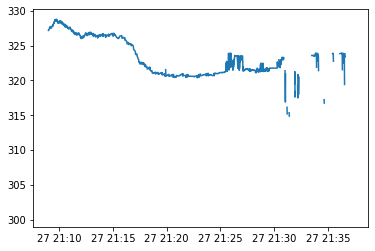

In [23]:
plt.plot(var.iloc[0:end+1])

In [8]:
#sns = pd.read_csv('VSE_Data_1Hz_gradtv.csv')
sns['TE_dist_new'] = np.nan
sns['TV_dist_new'] = np.nan

for SN in sns.index:
    if np.isnan(sns.loc[SN]['Ua']) == False:
        sns.loc[SN,'TE_dist_new'] = np.round(get_distdef_correctionAngle(sns.loc[SN], 'TE'),2)
        sns.loc[SN,'TV_dist_new'] = np.round(get_distdef_correctionAngle(sns.loc[SN], 'TV'),2)

In [11]:
sns.iloc[45]

date                    20170327
ID                         0222A
N_ID                         NaN
Lats                     34.5453
Lons                    -87.3081
mode                       mixed
type                           R
TOA                3/27/17 21:09
storm_ref_angle              -40
Ua                          17.3
Va                           6.9
TOA_mods                     NaN
Bsdist_mods                  8.5
TE_dist                    -7.13
TV_dist                    -7.85
dTVdn                       -2.6
storm_u_OLD                 18.4
storm_v_OLD                  3.7
TE_dist_new               -26.02
TV_dist_new                -8.89
Name: 45, dtype: object

In [10]:
print(sns['TE_dist'] - sns['TE_dist_new'])

0      2.49
1      0.00
2      1.89
3      0.02
4      0.00
5      0.15
6      1.93
7      0.00
8      0.00
9      0.02
10     0.22
11     0.12
12     0.18
13     0.70
14     0.24
15     0.76
16     0.28
17     1.20
18     0.00
19     0.57
20     0.75
21     0.18
22     0.65
23     0.67
24     0.12
25     0.00
26      NaN
27     0.00
28      NaN
29      NaN
      ...  
44     6.16
45    18.89
46     0.00
47     0.00
48     1.18
49     0.37
50     0.00
51     0.00
52     0.00
53     0.00
54     0.00
55     0.00
56     1.20
57     0.17
58     1.24
59     1.62
60     0.96
61     0.40
62     0.34
63     0.35
64     0.00
65     0.00
66     0.07
67     0.98
68     0.70
69     0.88
70     0.00
71     0.00
72     0.00
73     0.05
Length: 74, dtype: float64


# test plots

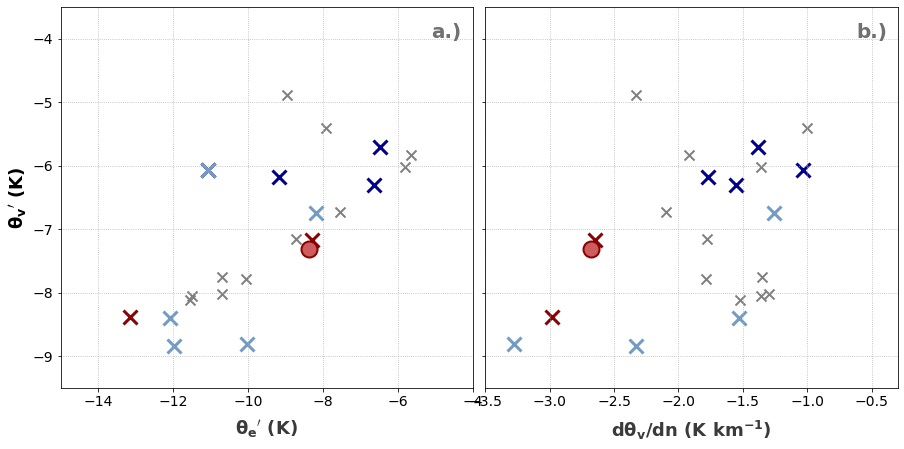

In [24]:
event = sns[sns['date']==20170430]
d_20170430 = event.set_index(event['ID'])

d_20170430= d_20170430.rename(columns={"TV_dist": "TV", "TE_dist": "TE"})


fig, [ax,ax2] = plt.subplots(1,2, figsize=(15,7), sharey=True)
# ax = axes[0]
# ax2 = axes[1]

#plt.title(r'10-min ${\theta_v}$ and ${\theta_e}$ Deficits',fontsize=24, y = 1.01)
ax.set_xlabel(r'$\mathbf{{\theta_e}^\prime}$ (K)', fontsize=18, labelpad = 10, weight='bold', color='#3a3a3a')
ax.set_ylabel(r'$\mathbf{{\theta_v}^\prime}$ (K)', fontsize=18, weight='bold')
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)

nontorsize = (14**2)
nonwidth=3

dist_10 = (16*16)
dist_15 = (10*10)
time_15 = '#350507'
time_10 = 'darkred'
time_5 = 'indianred'


#N = 6, 7, 11
#S =  2, 12, 221, 222, 14 

tor = [d_20170430.loc[['0107A']]['TE'],\
     d_20170430.loc['0107A']['TV']]
S = [d_20170430.loc[['0106A', '0111A']]['TE'],\
     d_20170430.loc[['0106A', '0111A']]['TV']]
N = [d_20170430.loc[['0102A','0214A','0112A','0220A']]['TE'],\
     d_20170430.loc[['0102A','0214A','0112A','0220A']]['TV']]
N2 =[d_20170430.loc[['0102A', '0217A','0221A','0222A','0218A']]['TE'],\
     d_20170430.loc[['0102A', '0217A','0221A','0222A','0218A']]['TV']]
n2 = ['0102A', '0217A','0221A','0222A','0218A']


# 20170430
ax.scatter(d_20170430['TE'].loc[~d_20170430.index.isin(n2)]\
        ,d_20170430['TV'].loc[~d_20170430.index.isin(n2)], marker='x',color='gray', s=(10**2), linewidth=2)

ax.scatter(S[0],S[1], marker='x', s=nontorsize,color='darkred',linewidth=nonwidth)
ax.scatter(N[0],N[1], marker='x', s=nontorsize,color='darkblue',linewidth=nonwidth)
ax.scatter(N2[0],N2[1], marker='x', s=nontorsize,color='#749cc2',alpha=1,linewidth=nonwidth)
# keep 
ax.scatter(tor[0],tor[1],\
        s=dist_10, color=time_5, linewidth=2, edgecolors='darkred') #107

ax.grid(linestyle=':')



# shapes = mlines.Line2D([],[], color = 'k', markersize=43,  marker = '$Feature Near Observation$',linewidth=0, label=r'')
# non = mlines.Line2D([],[], color = 'gray', markersize=10, mew='2',marker = 'x',linewidth=0, label=r'Other')
# Nnon = mlines.Line2D([],[], color = 'darkblue', markersize=12, mew='3', marker = 'x',linewidth=0, label=r'N Nontor MV')
# Nnon2 = mlines.Line2D([],[], color = '#749cc2', alpha=1,markersize=12, mew='3', marker = 'x',linewidth=0, label=r'S Nontor MV')
# Snon = mlines.Line2D([],[], color = 'darkred', markersize=12, mew='3', marker = 'x',linewidth=0, label=r'Near-Tor MV')
# tor = mlines.Line2D([],[], color = 'indianred',  markersize = 16,mew='2',marker = 'o', linewidth = 0,mec = 'darkred', label='Tornado')
# leg = ax.legend(handles = [tor,Snon, Nnon,Nnon2, non],
#                  loc=2, fontsize=14, title='Feature Near Ob.')
# leg.get_title().set_fontsize('15') 


ax.set_xlim(-15,-4);
ax.set_ylim(-9.5,-3.5);

ax.set_facecolor('w')
ax.patch.set_visible(False)

###########################


ax2.set_xlabel(r'$\mathbf{d\theta_v/{dn}}$ (K km$\mathbf{^{-1}}$)', fontsize=18, labelpad = 10, color='#3a3a3a', weight='bold')
#plt.ylabel(r'${\theta_v}$ Deficit (K)', fontsize=18)
ax2.tick_params(axis='y',labelsize=14)
ax2.tick_params(axis='x',labelsize=14)


n2 = ['0102A', '0217A','0221aA','0222A','0218A']

tor = [d_20170430.loc[['0107A']]['dTVdn'],\
     d_20170430.loc['0107A']['TV']]


S = [d_20170430.loc[['0106A', '0111A']]['dTVdn'],\
     d_20170430.loc[['0106A', '0111A']]['TV']]

N = [d_20170430.loc[['0214A', '0217A','0112A','0220A','0221A','0222A','0218A']]['dTVdn'],\
     d_20170430.loc[['0214A', '0217A','0112A','0220A','0221A','0222A','0218A']]['TV']]
N = [d_20170430.loc[['0102A','0214A','0112A','0220A']]['dTVdn'],\
     d_20170430.loc[['0102A','0214A','0112A','0220A']]['TV']]

N2 =[d_20170430.loc[[ '0217A','0221A','0222A','0218A']]['dTVdn'],\
     d_20170430.loc[[ '0217A','0221A','0222A','0218A']]['TV']]

# 20170430
ax2.scatter(d_20170430['dTVdn'].loc[~d_20170430.index.isin(n2)],\
        d_20170430['TV'].loc[~d_20170430.index.isin(n2)], marker='x',color='gray', s=(10**2), linewidth=2)

ax2.scatter(S[0],S[1], marker='x', s=nontorsize,color='darkred',linewidth=nonwidth)
ax2.scatter(N[0],N[1], marker='x', s=nontorsize,color='darkblue',linewidth=nonwidth)
ax2.scatter(N2[0],N2[1], marker='x', s=nontorsize,color='#749cc2', alpha=1,linewidth=nonwidth)

#ax2.scatter(d_20170430.loc[['0109A']]['dTVdn'], d_20170430.loc[['0109A']]['TV'], color='orange')

# keep 
ax2.scatter(tor[0],tor[1],\
        s=dist_10, color=time_5, linewidth=2, edgecolors='darkred') #107

ax2.grid(linestyle=':')


ax2.set_xlim(-3.5,-0.3);

ax2.set_facecolor('w')
ax2.patch.set_visible(False)

ax.text(0.9,0.92,'a.)', fontsize=20, transform=ax.transAxes,color='#6f7070',
           weight= 'bold')
ax2.text(0.9,0.92,'b.)', fontsize=20, transform=ax2.transAxes,color='#6f7070',
           weight= 'bold')
plt.subplots_adjust(wspace=.03)
plt.show()





In [327]:
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
#import cartopy.io.shapereader as shpreader
from metpy.plots import USCOUNTIES
#from WarningPoly import plot_warnings#_cartopy;

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib as mpl
import glob
import SNobject3 as sn
from matplotlib import colors as mcolors
import probe_info
from functions import calc_dewpoint,calc_thetae,calc_thetav,C_to_F,calc_mslp,convert_wind
import matplotlib.lines as mlines
from metpy.gridding import  (interpolate, remove_nan_observations,remove_repeat_coordinates)
import cmocean
import pickle
from WarningPoly import get_ww_fordate, plot_warnings#, plot_warning_filled
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from collections import OrderedDict
# Set up our projection
crs = ccrs.PlateCarree()
globe = ccrs.Globe(datum='WGS84',ellipse='sphere')

# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')

llcrnrlon=-87.7
llcrnrlat=34.1
urcrnrlon=-85.9
urcrnrlat=35.5

west_lon, east_lon = -87.7, -85.9
north_lat, south_lat=35.55, 34.1

#lon_add, lat_add
LL = (west_lon),(north_lat)
UR = (east_lon ),(south_lat)
LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())




Basemap not found. Only import cartopy functions.


/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/metpy/gridding.py:22: MetpyDeprecationWarning: The use of the "gridding" subpackage has been deprecated, and will be removed in 0.12. Use the "interpolate" subpackage instead.
  metpy.deprecation.metpyDeprecation)


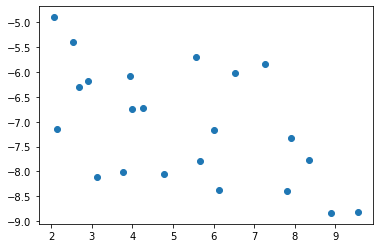

In [1060]:
plt.scatter(var, event['TV_dist'])

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel_launcher.py:10: MetpyDeprecationWarning: The interpolate function was deprecated in version 0.9. This function has been renamed interpolate_to_grid.
  # Remove the CWD from sys.path while we load stuff.


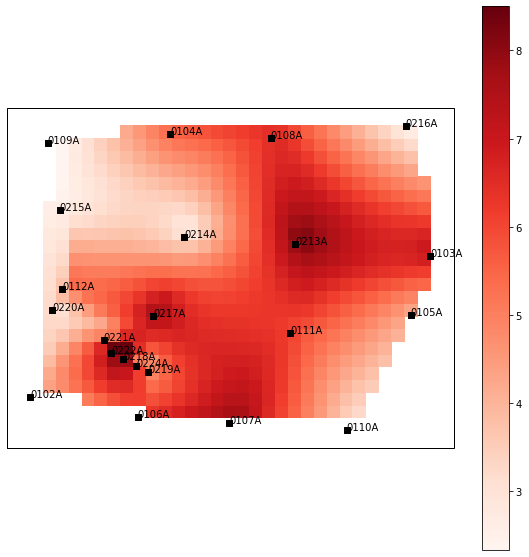

In [1059]:
event = sns[sns['date']==20170430]
lons = event['Lons']
lats = event['Lats']
ids = event['ID']
var = [get_ws(event.loc[i]) for i in event.index]#event['WS']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=crs)

gx,gy,img1 = interpolate(np.asarray(lons),np.asarray(lats),np.asarray(var),interp_type='natural_neighbor',hres=.05)

grid = ax.pcolormesh(gx,gy,img1, cmap='Reds')
plt.colorbar(grid)
ax.scatter(lons, lats, marker='s', color='k')

for i in ids.index:
    ax.text(lons[i],lats[i], ids[i])

In [957]:
event = event.set_index(event['ID'])

In [1050]:
def findnearest(array, value):
    array = np.asarray(array)
    return (np.abs(array-value)).argmin()


def get_maxwind(SN, def_dist=15*1000):
    ''' def_dist is the distance in km that the deficit is considered.
    default is 10km'''

    toa= pd.to_datetime(SN['TOA'])
    date = toa.strftime('%Y%m%d')
    met = get_1hz(date,snid[0:5], toa - dt.timedelta(minutes=45), 45) # pull 30 mins, should be more than enough 
    
    u = SN['storm_u']
    v = SN['storm_v']
    storm_speed = np.sqrt(u**2 + v**2)
    #print(met.index)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled
    

    # center new_dist on TOA, negative values are before TOA, postive are after
    toa_idx = np.where(met.index==toa)[0][0]
    new_dist = dist - dist[toa_idx]

    # find start and end for data based on distance before and after toa
    start_idx = findnearest(new_dist, -1*def_dist)
    end_idx = findnearest(new_dist, def_dist)
    new_dist = new_dist[start_idx: end_idx]
    ws = met['WS'][start_idx:end_idx]
    wd = met['WS'][start_idx:end_idx]
    u,v = convert_wind(ws, wd)
    max_3sec_gust = ws.rolling('3s').mean()#.resample('1s', label='right').max(),1)
    max_3sec_u = np.round( ws.rolling('3s').mean().resample('1s', label='right').mean(),1)
    
    max3 = sorted(max_3sec_gust, reverse=True)
    return  np.average(max3[0:20])#np.max(max_3sec_gust)#np.average(max3[0:1]) # average top 10 wind gusts

def get_maxwind_avg(SN, def_dist=5*1000):
    ''' def_dist is the distance in km that the deficit is considered.
    default is 10km'''

    toa= pd.to_datetime(SN['TOA'])
    date = toa.strftime('%Y%m%d')
    met = get_1hz(date,snid[0:5], toa - dt.timedelta(minutes=45), 45) # pull 30 mins, should be more than enough 
    
    u = SN['storm_u']
    v = SN['storm_v']
    storm_speed = np.sqrt(u**2 + v**2)
    #print(met.index)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled
    

    # center new_dist on TOA, negative values are before TOA, postive are after
    toa_idx = np.where(met.index==toa)[0][0]
    new_dist = dist - dist[toa_idx]

    # find start and end for data based on distance before and after toa
    start_idx = findnearest(new_dist, -1*def_dist)
    end_idx = findnearest(new_dist, def_dist)
    new_dist = new_dist[start_idx: end_idx]
    ws = met['WS'][start_idx:end_idx]
    wd = met['WS'][start_idx:end_idx]
    ws = ws[ws>=1.0]
#     u,v = convert_wind(ws, wd)
#     max_3sec_gust = ws.rolling('3s').mean()#.resample('1s', label='right').max(),1)
#     max_3sec_u = np.round( ws.rolling('3s').mean().resample('1s', label='right').mean(),1)
    
    return np.average(ws)
def get_ws(SN, pretoa=2*1000, posttoa=8*1000):
    ''' SN is the sticknet data
    pretoa is m before toa to start using data
    posttoa is m after toa to stop using data
    distance is distance in meters to calculated the max thetav change'''
    
    # check for empty files
    ref = SN['storm_ref_angle']
    if np.isnan(ref)!= True:
    
        snid = SN['ID']
        u = SN['storm_u']
        v = SN['storm_v']
        storm_speed = np.sqrt(u**2 + v**2)
        date = SN['date']
        toa = pd.to_datetime(SN['TOA'])

        # grab time 15 minutes before toa and 30 minutes after, should be big enough buffer
        met = get_1hz(date,snid[0:5], toa - dt.timedelta(minutes=15), 45)
     

        # create distance array based on correction angle
        delta_time = (met.index[:]-met.index[0]).seconds
        dist = storm_speed * delta_time
        theta_c = get_correction_angle(u,v,ref)
        new_dist = dist * np.cos(theta_c)

        # center new_dist on TOA, negative values are before TOA, postive are after
        toa_idx = np.where(met.index==toa)[0][0]
        new_dist = new_dist - new_dist[toa_idx]

        # find start and end for data based on distance before and after toa
        start_idx = findnearest(new_dist, -1*pretoa)
        end_idx = findnearest(new_dist, posttoa)
        new_dist = new_dist[start_idx: end_idx]
        ws = met['WS'][start_idx:end_idx]

        return np.average(ws) #np.percentile(ws, 75)

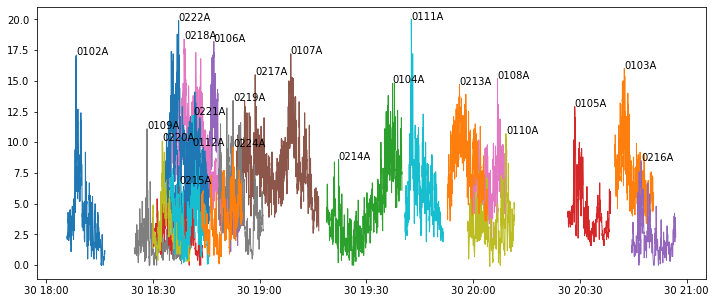

In [1038]:
event = sns[sns['date']==20170430]

fig = plt.figure(figsize=(12,5))
for i in event.index:
    ws = get_ws(event.loc[i])
    plt.plot(ws.index, ws, linewidth=1)
    maxval = findnearest(ws, np.max(ws))
    plt.text(ws.index[maxval], np.max(ws), event.loc[i]['ID'])

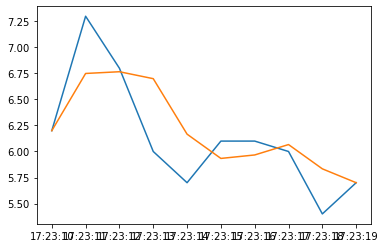

In [988]:
plt.plot(met['WS'][10:20])
plt.plot(met['WS'][10:20].rolling('3s').mean())#.resample('1s', label='right').max())

In [980]:
for i in event.index[0:1]:
    #print(i)
    
    met, m = get_maxwind(event.loc[i])

In [919]:
sns = sns.rename(columns={"TV_dist": "TV", "TE_dist": "TE"})
sns = sns.set_index(sns['ID'])
d_20160331=sns[sns['date']==20160331]
d_20160430=sns[sns['date']==20160430]
d_20170301=sns[sns['date']==20170301]
d_20170310=sns[sns['date']==20170310]
d_20170321=sns[sns['date']==20170321]
d_20170325=sns[sns['date']==20170325]
d_20170327=sns[sns['date']==20170327]
d_20170422=sns[sns['date']==20170422]
d_20170430=sns[sns['date']==20170430]

non_20160331 = d_20160331[d_20160331['type']=='R']['ID'].values
non_20160430 = d_20160430[d_20160430['type']=='R']['ID'].values
non_20170301 = d_20170301[d_20170301['type']=='R']['ID'].values
non_20170310 = d_20170310[d_20170310['type']=='R']['ID'].values
non_20170321 = d_20170321[d_20170321['type']=='R']['ID'].values
non_20170325 = d_20170325[d_20170325['type']=='R']['ID'].values
non_20170327 = d_20170327[d_20170327['type']=='R']['ID'].values
non_20170422 = d_20170422[d_20170422['type']=='R']['ID'].values
non_20170430 = d_20170430[d_20170430['type']=='R']['ID'].values

tor_20170310 = d_20170310[d_20170310['type']=='T']['ID'].values
tor_20170422 = d_20170422[d_20170422['type']=='T']['ID'].values
tor_20170430 = d_20170430[d_20170430['type']=='T']['ID'].values

def get_colors():
    supc = cmocean.cm.rain(0.25)#'#a8889f'
    mixc = cmocean.cm.rain(0.45)
    linc = cmocean.cm.rain(0.75)
    a =1
    a_tor=1
    return supc, mixc, linc, a, a_tor

import itertools
def get_total(var):
    ''' var is either str TV, TE, TVgrad, or Pres'''
    if var == 'TVgrad':
        var = 'dTVdn'
    total =[d_20160331.loc[non_20160331][var].values,d_20160430.loc[non_20160430][var].values,
            d_20170301.loc[non_20170301][var].values,d_20170310.loc[non_20170310][var].values,
            d_20170310.loc[tor_20170310][var].values,
            d_20170325.loc[non_20170325][var].values,d_20170327.loc[non_20170327][var].values,
            d_20170422.loc[non_20170422][var].values,d_20170422.loc[tor_20170422][var].values,
            d_20170430.loc[non_20170430][var].values,d_20170430.loc[tor_20170430][var].values]
    totalavg = np.average(list(itertools.chain(*total)))
    return totalavg

def get_sup(var):
    if var == 'TVgrad':
        var = 'dTVdn'
    total = [d_20160331.loc[non_20160331][var].values,d_20160430.loc[non_20160430][var].values,\
        d_20170301.loc[non_20170301][var].values,d_20170422.loc[non_20170422][var].values,\
        d_20170422.loc[tor_20170422][var].values]
    totalavg = np.average(list(itertools.chain(*total)))
   # print(len(list(itertools.chain(*total))))
    return totalavg

def get_mix(var):
    if var == 'TVgrad':
        var = 'dTVdn'
    total =[d_20170325.loc[non_20170325][var].values,d_20170327.loc[non_20170327][var].values]
    totalavg = np.average(list(itertools.chain(*total)))
    #print(len(list(itertools.chain(*total))))
    return totalavg
def get_lin(var):
    if var == 'TVgrad':
        var = 'dTVdn'
    total =[d_20170310.loc[non_20170310][var].values,d_20170310.loc[tor_20170310][var].values,
            d_20170430.loc[non_20170430][var].values,d_20170430.loc[tor_20170430][var].values,
            d_20170321.loc[non_20170321][var].values]
    totalavg = np.average(list(itertools.chain(*total)))
    #print(len(list(itertools.chain(*total))))
    return totalavg

Text(0.9, 0.92, 'b.)')

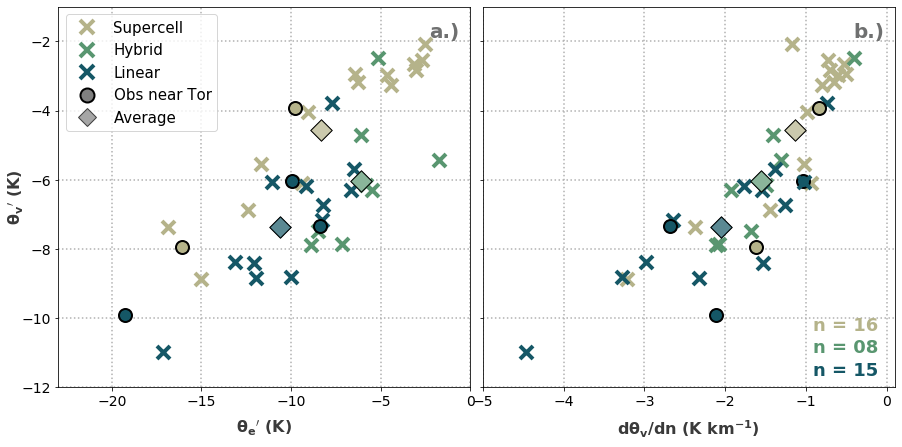

In [925]:





fig, [ax,ax2] = plt.subplots(1,2, figsize=(15,7), sharey=True)

plt.rc('axes', axisbelow=True)

ax.set_xlabel(r'$\mathbf{{\theta_e}^\prime}$ (K)', fontsize=16, labelpad = 10, weight='bold', color='#3a3a3a')
ax.set_ylabel(r'$\mathbf{{\theta_v}^\prime}$ (K)', fontsize=16, labelpad = -5, weight='bold', color='#3a3a3a')
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)

s= (13**2)
a=0.7
a_tor=0.8


supc = '#539b3e'#'#488236'#'#75ad74'#'#4e9678'
mixc = '#244f75'
linc = '#712e2e'#'#823e31'
nmark = 'x'
tormark = 'o'
lw = 4
lwt=2



supc, mixc, linc,a , a_tor = get_colors()


#20160331:
ax.scatter(d_20160331.loc[non_20160331]['TE'], d_20160331.loc[non_20160331]['TV'],
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw)

#20160430:
ax.scatter(d_20160430.loc[non_20160430]['TE'], d_20160430.loc[non_20160430]['TV'],
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw)

#20170301:
ax.scatter(d_20170301.loc[non_20170301]['TE'], d_20170301.loc[non_20170301]['TV'],
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw);

#20170310:
ax.scatter(d_20170310.loc[non_20170310]['TE'], d_20170310.loc[non_20170310]['TV'],
        color=linc, marker=nmark, s=s, alpha=a, linewidth=lw);
ax.scatter(d_20170310.loc[tor_20170310]['TE'], d_20170310.loc[tor_20170310]['TV'],
        color=linc, marker=tormark, s=s, alpha=a_tor, edgecolors='k', linewidth=lwt);

#20170321:
ax.scatter(d_20170321.loc[non_20170321]['TE'], d_20170321.loc[non_20170321]['TV'],
        color=linc, marker=nmark, s=s, alpha=a, linewidth=lw);

#20170325:
ax.scatter(d_20170325.loc[non_20170325]['TE'], d_20170325.loc[non_20170325]['TV'],
        color=mixc,marker=nmark, s=s, alpha=a, linewidth=lw);

#20170327:
ax.scatter(d_20170327.loc[non_20170327]['TE'], d_20170327.loc[non_20170327]['TV'],
        color=mixc,marker=nmark, s=s, alpha=a, linewidth=lw);

#20170422:
ax.scatter(d_20170422.loc[non_20170422]['TE'], d_20170422.loc[non_20170422]['TV'],
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw);
ax.scatter(d_20170422.loc[tor_20170422]['TE'], d_20170422.loc[tor_20170422]['TV'],
        color=supc, marker=tormark, s=s, alpha=a_tor, edgecolor='k', linewidth=lwt);

#20170430:
ax.scatter(d_20170430.loc[non_20170430]['TE'], d_20170430.loc[non_20170430]['TV'],
        color=linc, marker=nmark, s=s, alpha=a, linewidth=lw);
ax.scatter(d_20170430.loc[tor_20170430]['TE'], d_20170430.loc[tor_20170430]['TV'],
        color=linc, marker=tormark, s=s, alpha=a_tor, edgecolor='k', linewidth=lwt);

avgm = 'D'
avgs = (15**2)
avgec = 'k'
avglw = 1
avga = 0.7
# pLOT AVERAGES
ax.scatter(get_sup('TE'),get_sup('TV'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax.scatter(get_sup('TE'),get_sup('TV'), s=avgs, color=supc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax.scatter(get_mix('TE'),get_mix('TV'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax.scatter(get_mix('TE'),get_mix('TV'), s=avgs, color=mixc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax.scatter(get_lin('TE'),get_lin('TV'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax.scatter(get_lin('TE'),get_lin('TV'), s=avgs, color=linc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)


sup = mlines.Line2D([],[], color = supc, markersize=14, 
                    marker = 'x',linewidth=0, mew=lw, alpha=a, label=r'Supercell')
mix = mlines.Line2D([],[], color = mixc, markersize=14, 
                    marker = 'x',linewidth=0, mew=lw,alpha=a, label=r'Hybrid')
lin = mlines.Line2D([],[], color = linc, markersize=14, 
                    marker = 'x',linewidth=0, mew=lw, alpha=a,label=r'Linear')
Tor = mlines.Line2D([],[], color = 'gray', markersize=14,
                    marker = 'o',linewidth=0, mew=lwt, markeredgecolor='k',\
                    alpha=a_tor,label=r'Obs near Tor')
avg = mlines.Line2D([],[], color = 'gray', markersize=13,
                    marker = 'D',linewidth=0, mew=avglw, markeredgecolor='k',\
                    alpha=avga,label=r'Average')

ax.legend(handles = [sup, mix, lin, Tor, avg],loc=2 ,fontsize = 15);
ax.grid(zorder=0, linestyle=":", linewidth=1.5)

# ax.text(0.84, 0.17, 'n = 16', fontsize=18, color=supc, weight='bold', transform=ax.transAxes)
# ax.text(0.84, 0.11, 'n = 08', fontsize=18, color=mixc, weight='bold', transform=ax.transAxes)
# ax.text(0.84, 0.05, 'n = 15', fontsize=18, color=linc, weight='bold', transform=ax.transAxes)




##################################################
##################################################


ax2.set_xlabel(r'$\mathbf{d\theta_v/{dn}}$ (K km$\mathbf{^{-1}}$)', fontsize=16, labelpad = 10, weight='bold', color='#3a3a3a')
ax2.tick_params(axis='y',labelsize=14)
ax2.tick_params(axis='x',labelsize=14)


#20160331:
ax2.scatter(d_20160331.loc[non_20160331]['dTVdn'], d_20160331.loc[non_20160331]['TV'],
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw)

#20160430:
ax2.scatter(d_20160430.loc[non_20160430]['dTVdn'], d_20160430.loc[non_20160430]['TV'],
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw)

#20170301:
ax2.scatter(d_20170301.loc[non_20170301]['dTVdn'], d_20170301.loc[non_20170301]['TV'],
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw);

#20170310:
ax2.scatter(d_20170310.loc[non_20170310]['dTVdn'], d_20170310.loc[non_20170310]['TV'],
        color=linc, marker=nmark, s=s, alpha=a, linewidth=lw);
ax2.scatter(d_20170310.loc[tor_20170310]['dTVdn'], d_20170310.loc[tor_20170310]['TV'],
        color=linc, marker=tormark, s=s, alpha=a_tor, edgecolors='k', linewidth=lwt);

#20170321:
ax2.scatter(d_20170321.loc[non_20170321]['dTVdn'], d_20170321.loc[non_20170321]['TV'],
        color=linc, marker=nmark, s=s, alpha=a, linewidth=lw);

#20170325:
ax2.scatter(d_20170325.loc[non_20170325]['dTVdn'], d_20170325.loc[non_20170325]['TV'],
        color=mixc,marker=nmark, s=s, alpha=a, linewidth=lw);

#20170327:
ax2.scatter(d_20170327.loc[non_20170327]['dTVdn'], d_20170327.loc[non_20170327]['TV'],
        color=mixc,marker=nmark, s=s, alpha=a, linewidth=lw);

#20170422:
ax2.scatter(d_20170422.loc[non_20170422]['dTVdn'], d_20170422.loc[non_20170422]['TV'],
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw);
ax2.scatter(d_20170422.loc[tor_20170422]['dTVdn'], d_20170422.loc[tor_20170422]['TV'],
        color=supc, marker=tormark, s=s, alpha=a_tor, edgecolor='k', linewidth=lwt);

#20170430:
ax2.scatter(d_20170430.loc[non_20170430]['dTVdn'], d_20170430.loc[non_20170430]['TV'],
        color=linc, marker=nmark, s=s, alpha=a, linewidth=lw);
ax2.scatter(d_20170430.loc[tor_20170430]['dTVdn'], d_20170430.loc[tor_20170430]['TV'],
        color=linc, marker=tormark, s=s, alpha=a_tor, edgecolor='k', linewidth=lwt);

avgm = 'D'
avgs = (15**2)
avgec = 'k'
avglw = 1
avga = 0.7
# pLOT AVERAGES
ax2.scatter(get_sup('dTVdn'),get_sup('TV'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_sup('dTVdn'),get_sup('TV'), s=avgs, color=supc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_mix('dTVdn'),get_mix('TV'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_mix('dTVdn'),get_mix('TV'), s=avgs, color=mixc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_lin('dTVdn'),get_lin('TV'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_lin('dTVdn'),get_lin('TV'), s=avgs, color=linc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)

ax2.grid(zorder=0, linestyle=":", linewidth=1.5)


ax2.text(0.80, 0.15, 'n = 16', fontsize=18, color=supc, weight='bold', transform=ax2.transAxes)
ax2.text(0.80, 0.09, 'n = 08', fontsize=18, color=mixc, weight='bold', transform=ax2.transAxes)
ax2.text(0.80, 0.03, 'n = 15', fontsize=18, color=linc, weight='bold', transform=ax2.transAxes)




ax.set_xlim(-23, 0)
# ax.set_xlim(-22, 1);
ax.set_ylim(-12,-1);
ax2.set_xlim(-5, 0.1)

plt.subplots_adjust(wspace=.03)
ax.text(0.9,0.92,'a.)', fontsize=20, transform=ax.transAxes,color='#6f7070',
           weight= 'bold')
ax2.text(0.9,0.92,'b.)', fontsize=20, transform=ax2.transAxes,color='#6f7070',
           weight= 'bold')

#plt.savefig('{0}OverallDefs.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300);

In [166]:
BIAS = pd.read_csv('/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/Bias_2017.txt', 
                   index_col=[0], delim_whitespace=True)
BIAS.index =['0{}A'.format(b) for b in BIAS.index]


def get_BS_Magnitude(SN, myvar):
    def_dist = 15*1000 # 10 km, 10,000 m
    def_dist2 = 10*1000 # 8 km 

    PROBE = SN['ID']
    
    if PROBE == '0215A2':
        PROBE = '0215A1' # get BS from earlier SN, as described in Text
        
    starttime = pd.to_datetime(SN['TOA']) - dt.timedelta(minutes=30)
    met = get_1hz(SN['date'], PROBE[0:5], starttime, 30) # pull 30 mins, should be more than enough 

    u = SN['Ua']
    v = SN['Va']
    storm_speed = np.sqrt(u**2 + v**2)
    delta_time = (met.index[:]-met.index[0]).seconds
    dist = storm_speed * delta_time # distance traveled
    dist = abs(dist-dist[-1]) # distance going back in time starting at toa

    start = np.where(abs(dist-def_dist) == abs(dist-def_dist).min())[0][0] # find where dist closest to 15
    end = np.where(abs(dist-def_dist2) == abs(dist-def_dist2).min())[0][0] # find where dist closest to 10
    change = np.nan
    
    #correction for short starts
    deldist = (def_dist-def_dist2) # delta distance from specified start and end distances
    if (end - start) < (deldist/storm_speed - 10) : # see if you have correct number of points
        start = 0
        ndist = storm_speed * delta_time
        end = np.where(abs(ndist-deldist) == abs(ndist-deldist).min())[0][0] # find 5 km from where data starts
        change = (ndist-ndist[-1])[0]
    
    if PROBE not in ['0218A','0219A','0220A', '0221A', '0222A','0223A','0224A']:
        T = met['T'] - BIAS.loc[PROBE[0:5]]['T']
        RH = met['RH'] - BIAS.loc[PROBE[0:5]]['RH']
        P = met['P'] - BIAS.loc[PROBE[0:5]]['P']
    else:
        T = met['T']; RH=met['RH']; P = met['P']
    dewp = calc_dewpoint(T,RH)
    if myvar == 'TV':
        var = calc_thetav(T, dewp, P)
    if myvar == 'TE':
        var = calc_thetae(T, dewp, P)

    bs = np.mean(var[start:end])
    return bs #met.index[start], met.index[end], change #<- use these when making methods plots

In [181]:
event.loc[SN]['TV_dist']

-7.4

In [186]:
event = sns.loc[8:].copy()
#event = event.iloc[0:16]
#event.index = event['ID']
event['TVdef_corrected'] = np.nan
event['TEdef_corrected'] = np.nan
 
for SN in event.index:
    if np.isnan(event.loc[SN]['Ua']) == False:
        event.loc[SN,'TVdef_corrected'] = get_BS_Magnitude(event.loc[SN], 'TV')#event.loc[SN]['TV_dist'] + get_BS_Magnitude(event.loc[SN], 'TV')
        event.loc[SN,'TEdef_corrected'] = get_BS_Magnitude(event.loc[SN], 'TE')#event.loc[SN]['TE_dist'] + get_BS_Magnitude(event.loc[SN], 'TE')

In [184]:
event

date     ID  N_ID       Lats       Lons       mode type  \
8   20170301  0103A   NaN  34.378112 -86.912166  supercell    R   
9   20170301  0109A   NaN  34.313122 -86.900077  supercell    R   
10  20170301  0217A  SDTR  34.617600 -87.101400  supercell    R   
11  20170310  0102A  SHYL  34.295900 -87.587100     linear   NR   
12  20170310  0103A  SCMT  34.855100 -86.001700     linear   NR   
13  20170310  0104A  SLYN  35.339100 -87.032400     linear    R   
14  20170310  0105A  SSBR  34.622400 -86.080000     linear   NR   
15  20170310  0107A  SCLM  34.194390 -86.798250     linear   NR   
16  20170310  0108A  SPBG  35.323600 -86.634700     linear    T   
17  20170310  0109A  SLBG  35.304500 -87.518500     linear   NR   
18  20170310  0110A  SDGS  34.163200 -86.334100     linear   NR   
19  20170310  0111A  SLYS  34.550400 -86.558200     linear   NR   
20  20170310  0112A  SLGN  34.725400 -87.462500     linear   NR   
21  20170310  0213A  SHLG  34.901600 -86.538600     linear   NR   
22  20170310  0214A  SEMT  34.930900 -86.976400     linear   NR   
23  20170310  0215A  SSJH  35.038000 -87.471900     linear   NR   
24  20170310  0216A  STLM  35.371900 -86.099800     linear    T   
25  20170310  0217A  SDTR  34.617600 -87.101400     linear   NR   
26  20170321  0103A  SCMT  34.855100 -86.001700     linear   NR   
27  20170321  0104A  SLYN  35.339100 -87.032400     linear    R   
28  20170321  0105A  SSBR  34.622400 -86.080000     linear   NR   
29  20170321  0107A  SCLM  34.194390 -86.798250     linear   NR   
30  20170321  0109A  SLBG  35.304500 -87.518500     linear   NR   
31  20170321  0110A  SDGS  34.163200 -86.334100     linear   NR   
32  20170321  0111A  SLYS  34.550400 -86.558200     linear   NR   
33  20170321  0213A  SHLG  34.901600 -86.538600     linear   NR   
34  20170321  0214A  SEMT  34.930900 -86.976400     linear   NR   
35  20170321  0215A  SSJH  35.038000 -87.471900     linear   NR   
36  20170321  0216A  STLM  35.371900 -86.099800     linear   NR   
37  20170321  0217A  SDTR  34.617600 -87.101400     linear   NR   
..       ...    ...   ...        ...        ...        ...  ...   
44  20170327  0217A  SDTR  34.617600 -87.101400      mixed    R   
45  20170327  0222A   NaN  34.545342 -87.308107      mixed    R   
46  20170430  0102A  SHYL  34.295900 -87.587100     linear    R   
47  20170430  0103A  SCMT  34.855100 -86.001700     linear   NR   
48  20170430  0104A  SLYN  35.339100 -87.032400     linear   NR   
49  20170430  0105A  SSBR  34.622400 -86.080000     linear   NR   
50  20170430  0106A  SADN  34.214900 -87.161900     linear    R   
51  20170430  0107A  SCLM  34.194390 -86.798250     linear    T   
52  20170430  0108A  SPBG  35.323600 -86.634700     linear   NR   
53  20170430  0109A  SLBG  35.304500 -87.518500     linear   NR   
54  20170430  0110A  SDGS  34.163200 -86.334100     linear   NR   
55  20170430  0111A  SLYS  34.550400 -86.558200     linear    R   
56  20170430  0112A  SLGN  34.725400 -87.462500     linear    R   
57  20170430  0213A  SHLG  34.901600 -86.538600     linear   NR   
58  20170430  0214A  SEMT  34.930900 -86.976400     linear    R   
59  20170430  0215A  SSJH  35.038000 -87.471900     linear   NR   
60  20170430  0216A  STLM  35.371900 -86.099800     linear   NR   
61  20170430  0217A  SDTR  34.617600 -87.101400     linear    R   
62  20170430  0218A   NaN  34.448162 -87.219750     linear    R   
63  20170430  0219A   NaN  34.394485 -87.120229     linear   NR   
64  20170430  0220A   NaN  34.639214 -87.500392     linear    R   
65  20170430  0221A   NaN  34.523322 -87.296503     linear    R   
66  20170430  0222A   NaN  34.472091 -87.267640     linear    R   
67  20170430  0224A   NaN  34.420291 -87.169020     linear   NR   
68  20170422  0102A  SHYL  34.295900 -87.587100  supercell    R   
69  20170422  0103A  SCMT  34.855100 -86.001700  supercell    T   
70  20170422  0106A  SADN  34.214900 -87.161900  supercell    T   
71  20170422  0107A  SCLM  34.194390 -86.798250  superc

In [173]:
def get_colors():
    supc = cmocean.cm.rain(0.25)
    mixc = cmocean.cm.rain(0.45)
    linc = cmocean.cm.rain(0.75)
    a =1
    a_tor=1
    return supc, mixc, linc, a, a_tor

def get_mode_average(var, mode):
    ''' var == dTVdn, TE, or TV
    mode is linear, supercell, or mixed, or all'''
    if mode == 'all':
        average = np.average(event[event['type']!='NR'][var])
    else:
        average = np.average(event[(event['mode']==mode) & (event['type']!='NR')][var])
    return average

def get_mode(var, mode, typ):
    ''' var == dTVdn, TE, or TV
    mode is linear, supercell, or mixed
    typ is R or T'''
    return event[(event['mode']==mode) & (event['type']==typ)][var]


In [177]:
event

date     ID  N_ID       Lats       Lons       mode type  \
8   20170301  0103A   NaN  34.378112 -86.912166  supercell    R   
9   20170301  0109A   NaN  34.313122 -86.900077  supercell    R   
10  20170301  0217A  SDTR  34.617600 -87.101400  supercell    R   
11  20170310  0102A  SHYL  34.295900 -87.587100     linear   NR   
12  20170310  0103A  SCMT  34.855100 -86.001700     linear   NR   
13  20170310  0104A  SLYN  35.339100 -87.032400     linear    R   
14  20170310  0105A  SSBR  34.622400 -86.080000     linear   NR   
15  20170310  0107A  SCLM  34.194390 -86.798250     linear   NR   
16  20170310  0108A  SPBG  35.323600 -86.634700     linear    T   
17  20170310  0109A  SLBG  35.304500 -87.518500     linear   NR   
18  20170310  0110A  SDGS  34.163200 -86.334100     linear   NR   
19  20170310  0111A  SLYS  34.550400 -86.558200     linear   NR   
20  20170310  0112A  SLGN  34.725400 -87.462500     linear   NR   
21  20170310  0213A  SHLG  34.901600 -86.538600     linear   NR   
22  20170310  0214A  SEMT  34.930900 -86.976400     linear   NR   
23  20170310  0215A  SSJH  35.038000 -87.471900     linear   NR   
24  20170310  0216A  STLM  35.371900 -86.099800     linear    T   
25  20170310  0217A  SDTR  34.617600 -87.101400     linear   NR   
26  20170321  0103A  SCMT  34.855100 -86.001700     linear   NR   
27  20170321  0104A  SLYN  35.339100 -87.032400     linear    R   
28  20170321  0105A  SSBR  34.622400 -86.080000     linear   NR   
29  20170321  0107A  SCLM  34.194390 -86.798250     linear   NR   
30  20170321  0109A  SLBG  35.304500 -87.518500     linear   NR   
31  20170321  0110A  SDGS  34.163200 -86.334100     linear   NR   
32  20170321  0111A  SLYS  34.550400 -86.558200     linear   NR   
33  20170321  0213A  SHLG  34.901600 -86.538600     linear   NR   
34  20170321  0214A  SEMT  34.930900 -86.976400     linear   NR   
35  20170321  0215A  SSJH  35.038000 -87.471900     linear   NR   
36  20170321  0216A  STLM  35.371900 -86.099800     linear   NR   
37  20170321  0217A  SDTR  34.617600 -87.101400     linear   NR   
..       ...    ...   ...        ...        ...        ...  ...   
44  20170327  0217A  SDTR  34.617600 -87.101400      mixed    R   
45  20170327  0222A   NaN  34.545342 -87.308107      mixed    R   
46  20170430  0102A  SHYL  34.295900 -87.587100     linear    R   
47  20170430  0103A  SCMT  34.855100 -86.001700     linear   NR   
48  20170430  0104A  SLYN  35.339100 -87.032400     linear   NR   
49  20170430  0105A  SSBR  34.622400 -86.080000     linear   NR   
50  20170430  0106A  SADN  34.214900 -87.161900     linear    R   
51  20170430  0107A  SCLM  34.194390 -86.798250     linear    T   
52  20170430  0108A  SPBG  35.323600 -86.634700     linear   NR   
53  20170430  0109A  SLBG  35.304500 -87.518500     linear   NR   
54  20170430  0110A  SDGS  34.163200 -86.334100     linear   NR   
55  20170430  0111A  SLYS  34.550400 -86.558200     linear    R   
56  20170430  0112A  SLGN  34.725400 -87.462500     linear    R   
57  20170430  0213A  SHLG  34.901600 -86.538600     linear   NR   
58  20170430  0214A  SEMT  34.930900 -86.976400     linear    R   
59  20170430  0215A  SSJH  35.038000 -87.471900     linear   NR   
60  20170430  0216A  STLM  35.371900 -86.099800     linear   NR   
61  20170430  0217A  SDTR  34.617600 -87.101400     linear    R   
62  20170430  0218A   NaN  34.448162 -87.219750     linear    R   
63  20170430  0219A   NaN  34.394485 -87.120229     linear   NR   
64  20170430  0220A   NaN  34.639214 -87.500392     linear    R   
65  20170430  0221A   NaN  34.523322 -87.296503     linear    R   
66  20170430  0222A   NaN  34.472091 -87.267640     linear    R   
67  20170430  0224A   NaN  34.420291 -87.169020     linear   NR   
68  20170422  0102A  SHYL  34.295900 -87.587100  supercell    R   
69  20170422  0103A  SCMT  34.855100 -86.001700  supercell    T   
70  20170422  0106A  SADN  34.214900 -87.161900  supercell    T   
71  20170422  0107A  SCLM  34.194390 -86.798250  superc

Text(0.92, 0.92, 'b)')

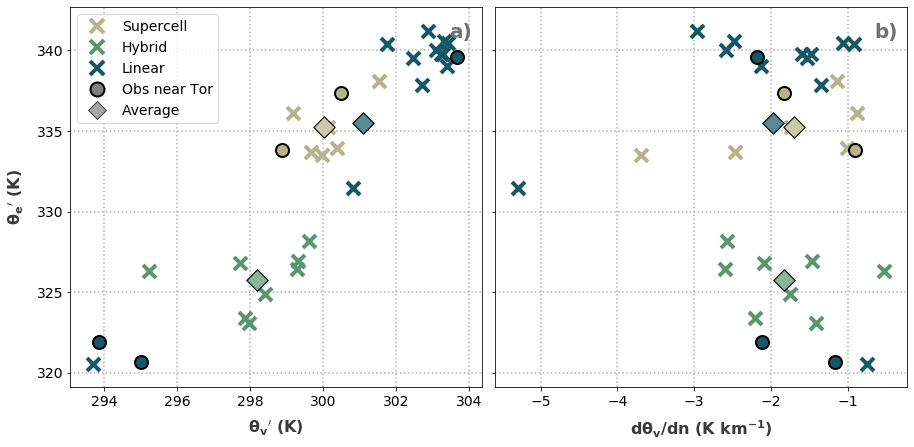

In [188]:
fig, [ax,ax2] = plt.subplots(1,2, figsize=(15,7), sharey=True)

plt.rc('axes', axisbelow=True)
# pull in plotting variables 
s= (13**2)
nmark = 'x'
tormark = 'o'
lw = 4
lwt=2
avgm = 'D'
avgs = (15**2)
avgec = 'k'
avglw = 1
avga = 0.7
supc, mixc, linc, a, a_tor = get_colors()

##################################################
# thetae vs thetav
##################################################

ax.set_xlabel(r'$\mathbf{{\theta_v}^\prime}$ (K)', fontsize=16, labelpad = 10, weight='bold', color='#3a3a3a')
ax.set_ylabel(r'$\mathbf{{\theta_e}^\prime}$ (K)', fontsize=16, labelpad = 10, weight='bold', color='#3a3a3a')
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)


# supercells
ax.scatter(get_mode('TVdef_corrected', 'supercell', 'R'), get_mode('TEdef_corrected', 'supercell', 'R'),
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw)

ax.scatter(get_mode('TVdef_corrected', 'supercell', 'T'), get_mode('TEdef_corrected', 'supercell', 'T'),
        color=supc, marker=tormark, s=s, alpha=a_tor, edgecolor='k', linewidth=lwt);

# hybrid 
ax.scatter(get_mode('TVdef_corrected', 'mixed', 'R'), get_mode('TEdef_corrected', 'mixed', 'R'),
        color=mixc, marker=nmark, s=s, alpha=a, linewidth=lw);

# linear
ax.scatter(get_mode('TVdef_corrected', 'linear', 'R'), get_mode('TEdef_corrected', 'linear', 'R'),
        color=linc, marker=nmark, s=s, alpha=a, linewidth=lw);

ax.scatter(get_mode('TVdef_corrected', 'linear', 'T'), get_mode('TEdef_corrected', 'linear', 'T'),
        color=linc, marker=tormark, s=s, alpha=a_tor, edgecolor='k', linewidth=lwt);


# pLOT AVERAGES
ax.scatter(get_mode_average('TVdef_corrected','supercell'),get_mode_average('TEdef_corrected','supercell'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
      linewidths=avglw)
ax.scatter(get_mode_average('TVdef_corrected','supercell'),get_mode_average('TEdef_corrected','supercell'), s=avgs, color=supc, alpha=avga, marker=avgm, edgecolor=avgec,\
      linewidths=avglw)
ax.scatter(get_mode_average('TVdef_corrected', 'mixed'),get_mode_average('TEdef_corrected', 'mixed'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
      linewidths=avglw)
ax.scatter(get_mode_average('TVdef_corrected', 'mixed'),get_mode_average('TEdef_corrected', 'mixed'), s=avgs, color=mixc, alpha=avga, marker=avgm, edgecolor=avgec,\
      linewidths=avglw)
ax.scatter(get_mode_average('TVdef_corrected', 'linear'),get_mode_average('TEdef_corrected', 'linear'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
      linewidths=avglw)
ax.scatter(get_mode_average('TVdef_corrected', 'linear'),get_mode_average('TEdef_corrected', 'linear'), s=avgs, color=linc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)


sup = mlines.Line2D([],[], color = supc, markersize=14, 
                    marker = 'x',linewidth=0, mew=lw, alpha=a, label=r'Supercell')
mix = mlines.Line2D([],[], color = mixc, markersize=14, 
                    marker = 'x',linewidth=0, mew=lw,alpha=a, label=r'Hybrid')
lin = mlines.Line2D([],[], color = linc, markersize=14, 
                    marker = 'x',linewidth=0, mew=lw, alpha=a,label=r'Linear')
Tor = mlines.Line2D([],[], color = 'gray', markersize=14,
                    marker = 'o',linewidth=0, mew=lwt, markeredgecolor='k',\
                    alpha=a_tor,label=r'Obs near Tor')
avg = mlines.Line2D([],[], color = 'gray', markersize=13,
                    marker = 'D',linewidth=0, mew=avglw, markeredgecolor='k',\
                    alpha=avga,label=r'Average')

ax.legend(handles = [sup, mix, lin, Tor, avg],loc=2 ,fontsize = 14);
ax.grid(zorder=0, linestyle=":", linewidth=1.5)

##################################################
# dTVdn vs thetav
##################################################

ax2.set_xlabel(r'$\mathbf{d\theta_v/{dn}}$ (K km$\mathbf{^{-1}}$)', fontsize=16, labelpad = 10, weight='bold', color='#3a3a3a')
ax2.tick_params(axis='y',labelsize=14)
ax2.tick_params(axis='x',labelsize=14)

# supercells
ax2.scatter(get_mode('dTVdn', 'supercell', 'R'), get_mode('TEdef_corrected', 'supercell', 'R'),
        color=supc, marker=nmark, s=s, alpha=a, linewidth=lw)

ax2.scatter(get_mode('dTVdn', 'supercell', 'T'), get_mode('TEdef_corrected', 'supercell', 'T'),
        color=supc, marker=tormark, s=s, alpha=a_tor, edgecolor='k', linewidth=lwt);

# hybrid 
ax2.scatter(get_mode('dTVdn', 'mixed', 'R'), get_mode('TEdef_corrected', 'mixed', 'R'),
        color=mixc, marker=nmark, s=s, alpha=a, linewidth=lw);

# linear
ax2.scatter(get_mode('dTVdn', 'linear', 'R'), get_mode('TEdef_corrected', 'linear', 'R'),
        color=linc, marker=nmark, s=s, alpha=a, linewidth=lw);

ax2.scatter(get_mode('dTVdn', 'linear', 'T'), get_mode('TEdef_corrected', 'linear', 'T'),
        color=linc, marker=tormark, s=s, alpha=a_tor, edgecolor='k', linewidth=lwt);


# pLOT AVERAGES
ax2.scatter(get_mode_average('dTVdn','supercell'),get_mode_average('TEdef_corrected','supercell'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_mode_average('dTVdn','supercell'),get_mode_average('TEdef_corrected','supercell'), s=avgs, color=supc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_mode_average('dTVdn', 'mixed'),get_mode_average('TEdef_corrected', 'mixed'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_mode_average('dTVdn', 'mixed'),get_mode_average('TEdef_corrected', 'mixed'), s=avgs, color=mixc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_mode_average('dTVdn', 'linear'),get_mode_average('TEdef_corrected', 'linear'), s=avgs, color='w', alpha=1, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)
ax2.scatter(get_mode_average('dTVdn', 'linear'),get_mode_average('TEdef_corrected', 'linear'), s=avgs, color=linc, alpha=avga, marker=avgm, edgecolor=avgec,\
       linewidths=avglw)

ax2.grid(zorder=0, linestyle=":", linewidth=1.5)


# ax2.text(0.80, 0.15, 'n = 16', fontsize=18, color=supc, weight='bold', transform=ax2.transAxes)
# ax2.text(0.80, 0.09, 'n = 08', fontsize=18, color=mixc, weight='bold', transform=ax2.transAxes)
# ax2.text(0.80, 0.03, 'n = 15', fontsize=18, color=linc, weight='bold', transform=ax2.transAxes)

#ax.set_ylim(-22, 1.5)
# ax.set_xlim(-22, 1);
#ax.set_xlim(-13,-.5);
#ax2.set_xlim(-5.8, 0)

plt.subplots_adjust(wspace=.03)
ax.text(0.92,0.92,'a)', fontsize=20, transform=ax.transAxes,color='#6f7070',
           weight= 'bold')
ax2.text(0.92,0.92,'b)', fontsize=20, transform=ax2.transAxes,color='#6f7070',
           weight= 'bold')

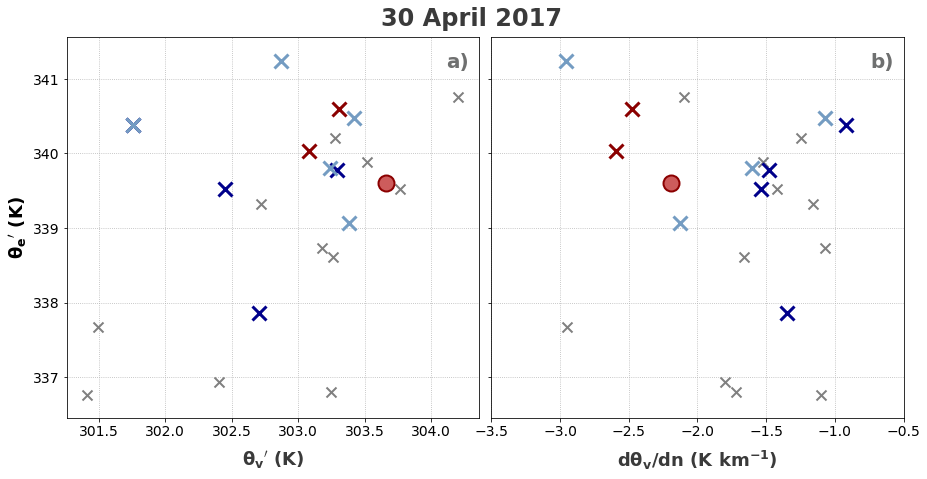

In [193]:
d_20170430 = event[event['date']==20170430]
d_20170430 = d_20170430.set_index(d_20170430['ID'])

d_20170430= d_20170430.rename(columns={"TV_dist": "TV", "TE_dist": "TE"})


fig, [ax,ax2] = plt.subplots(1,2, figsize=(15,7), sharey=True)
# ax = axes[0]
# ax2 = axes[1]

#plt.title(r'10-min ${\theta_v}$ and ${\theta_e}$ Deficits',fontsize=24, y = 1.01)
ax.set_xlabel(r'$\mathbf{{\theta_v}^\prime}$ (K)', fontsize=18, labelpad = 10, weight='bold', color='#3a3a3a')
ax.set_ylabel(r'$\mathbf{{\theta_e}^\prime}$ (K)', fontsize=18, weight='bold')
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)

nontorsize = (14**2)
nonwidth=3

dist_10 = (16*16)
dist_15 = (10*10)
time_15 = '#350507'
time_10 = 'darkred'
time_5 = 'indianred'


#N = 6, 7, 11
#S =  2, 12, 221, 222, 14 

tor = [d_20170430.loc[['0107A']]['TVdef_corrected'],\
     d_20170430.loc['0107A']['TEdef_corrected']]
S = [d_20170430.loc[['0106A', '0111A']]['TVdef_corrected'],\
     d_20170430.loc[['0106A', '0111A']]['TEdef_corrected']]
N = [d_20170430.loc[['0102A','0214A','0112A','0220A']]['TVdef_corrected'],\
     d_20170430.loc[['0102A','0214A','0112A','0220A']]['TEdef_corrected']]
N2 =[d_20170430.loc[['0102A', '0217A','0221A','0222A','0218A']]['TVdef_corrected'],\
     d_20170430.loc[['0102A', '0217A','0221A','0222A','0218A']]['TEdef_corrected']]
n2 = ['0102A', '0217A','0221A','0222A','0218A']


# 20170430
ax.scatter(d_20170430['TVdef_corrected'].loc[~d_20170430.index.isin(n2)]\
        ,d_20170430['TEdef_corrected'].loc[~d_20170430.index.isin(n2)], marker='x',color='gray', s=(10**2), linewidth=2)

ax.scatter(S[0],S[1], marker='x', s=nontorsize,color='darkred',linewidth=nonwidth)
ax.scatter(N[0],N[1], marker='x', s=nontorsize,color='darkblue',linewidth=nonwidth)
ax.scatter(N2[0],N2[1], marker='x', s=nontorsize,color='#749cc2',alpha=1,linewidth=nonwidth)
# keep 
ax.scatter(tor[0],tor[1],\
        s=dist_10, color=time_5, linewidth=2, edgecolors='darkred') #107

ax.grid(linestyle=':')



shapes = mlines.Line2D([],[], color = 'k', markersize=43,  marker = '$Feature Near Observation$',linewidth=0, label=r'')
non = mlines.Line2D([],[], color = 'gray', markersize=10, mew='2',marker = 'x',linewidth=0, label=r'Non-rotating')
Nnon = mlines.Line2D([],[], color = 'darkblue', markersize=12, mew='3', marker = 'x',linewidth=0, label=r'N Nontor Mesovortex')
Nnon2 = mlines.Line2D([],[], color = '#749cc2', alpha=1,markersize=12, mew='3', marker = 'x',linewidth=0, label=r'S Nontor Mesovortex')
Snon = mlines.Line2D([],[], color = 'darkred', markersize=12, mew='3', marker = 'x',linewidth=0, label=r'Near-Tor Mesovortex')
tor = mlines.Line2D([],[], color = 'indianred',  markersize = 16,mew='2',marker = 'o', linewidth = 0,mec = 'darkred', label='Tornado')
# leg = ax.legend(handles = [tor,Snon, Nnon,Nnon2, non],
#                  loc=2, fontsize=13)#,title='Feature Near Observation')
# leg.get_title().set_fontsize('15') 




ax.set_facecolor('w')
ax.patch.set_visible(False)

###########################


ax2.set_xlabel(r'$\mathbf{d\theta_v/{dn}}$ (K km$\mathbf{^{-1}}$)', fontsize=18, labelpad = 10, color='#3a3a3a', weight='bold')
#plt.ylabel(r'${\theta_v}$ Deficit (K)', fontsize=18)
ax2.tick_params(axis='y',labelsize=14)
ax2.tick_params(axis='x',labelsize=14)


n2 = ['0102A', '0217A','0221aA','0222A','0218A']

tor = [d_20170430.loc[['0107A']]['dTVdn'],\
     d_20170430.loc['0107A']['TEdef_corrected']]


S = [d_20170430.loc[['0106A', '0111A']]['dTVdn'],\
     d_20170430.loc[['0106A', '0111A']]['TEdef_corrected']]

N = [d_20170430.loc[['0214A', '0217A','0112A','0220A','0221A','0222A','0218A']]['dTVdn'],\
     d_20170430.loc[['0214A', '0217A','0112A','0220A','0221A','0222A','0218A']]['TEdef_corrected']]
N = [d_20170430.loc[['0102A','0214A','0112A','0220A']]['dTVdn'],\
     d_20170430.loc[['0102A','0214A','0112A','0220A']]['TEdef_corrected']]

N2 =[d_20170430.loc[[ '0217A','0221A','0222A','0218A']]['dTVdn'],\
     d_20170430.loc[[ '0217A','0221A','0222A','0218A']]['TEdef_corrected']]

# 20170430
ax2.scatter(d_20170430['dTVdn'].loc[~d_20170430.index.isin(n2)],\
        d_20170430['TEdef_corrected'].loc[~d_20170430.index.isin(n2)], marker='x',color='gray', s=(10**2), linewidth=2)

ax2.scatter(S[0],S[1], marker='x', s=nontorsize,color='darkred',linewidth=nonwidth)
ax2.scatter(N[0],N[1], marker='x', s=nontorsize,color='darkblue',linewidth=nonwidth)
ax2.scatter(N2[0],N2[1], marker='x', s=nontorsize,color='#749cc2', alpha=1,linewidth=nonwidth)

#ax2.scatter(d_20170430.loc[['0109A']]['dTVdn'], d_20170430.loc[['0109A']]['TVdef_corrected'], color='orange')

# keep 
ax2.scatter(tor[0],tor[1],\
        s=dist_10, color=time_5, linewidth=2, edgecolors='darkred') #107

ax2.grid(linestyle=':')

# for i in d_20170430.index:
#     ax2.text(d_20170430.loc[i]['dTVdn']+0.05,d_20170430.loc[i]['TEdef_corrected']+0.05, str(i) )

# ax.set_xlim(-10,-3.5);
# ax.set_ylim(-14,-2);

ax2.set_xlim(-3.5,-0.5);

ax2.set_facecolor('w')
ax2.patch.set_visible(False)

ax.text(0.92,0.92,'a)', fontsize=20, transform=ax.transAxes,color='#6f7070',
           weight= 'bold')
ax2.text(0.92,0.92,'b)', fontsize=20, transform=ax2.transAxes,color='#6f7070',
           weight= 'bold')
plt.subplots_adjust(wspace=.03)
plt.suptitle('30 April 2017', fontsize=24, weight='bold', color='#3a3a3a', y=.94)
#plt.savefig('{0}30AprilDefs.png'.format(save_dir), bbox_inches = 'tight', format='png', dpi=300);
plt.show()

In [205]:
np.percentile(d_20170430[0:16]['TEdef_corrected'])#-d_20170430['TEdef_corrected'].min()

339.06208745306145

In [208]:
from scipy import stats
stats.percentileofscore(d_20170430['TEdef_corrected'], d_20170430.loc['0107A']['TEdef_corrected'])

54.54545454545455

# calculating new deficits - OLD METHODS

In [395]:
def get_BaseState(SN, myvar):
   
    toa = pd.to_datetime(SN['TOA'])
 
    starttime = toa - dt.timedelta(minutes=20)
    
    met = get_1hz(SN['date'], SN['ID'][0:5], starttime, 20)

    # if data starts after TOA, the get_data function returns the soonest available point
    # so we can just start with the zeroth point (this won't go past TOA since worst is +13 minutes)
    met = met[:met.index[0]+dt.timedelta(seconds=299)] # this returns 300 data points. Since each point represents
                        # the minute previous, this is truly a five minute chunk (5 * 60)
    dewp = calc_dewpoint(met['T'],met['RH'])
    if myvar == 'TV':
        var = calc_thetav(met['T'], dewp, met['P'])
    if myvar == 'TE':
        var = calc_thetae(met['T'], dewp, met['P'])

    bs = np.mean(var)
    return bs

# 0215A2 from 31 Mar 2016 uses the basestate from 0215A1


def get_Deficit(SN, myvar):

    starttime = pd.to_datetime(SN['TOA'])
    endtime = starttime + dt.timedelta(seconds=599)
    
    met = get_1hz(SN['date'], SN['ID'][0:5], starttime, 10)
    met = met[starttime:endtime] # shaves off the dumb extra second
    
    dewp = calc_dewpoint(met['T'],met['RH'])
    if myvar == 'TV':
        var = calc_thetav(met['T'], dewp, met['P'])
    if myvar == 'TE':
        var = calc_thetae(met['T'], dewp, met['P'])
        
    bs = get_BaseState(SN, myvar)
    minval = np.min(var)

    if SN['ID'] == '0215A2':
        fix_0215A2 = {'TE':331.6577260777935, 
                      'TV':297.99200789919433}
        bs = fix_0215A2[myvar]

    return minval - bs
    